#### W tym projekcie pokażę jak wykorzystać uczenie maszynowe do przewidywania czy dany klient zrezygnuje z usług firmy telekominikacyjnej (churn) czy nadal będzie jego klientem. Pokażę jak dobrać najlepsze algorytmy dla tego problemu oraz hiperparametry (zarówno te bezpośrednio z nimi związane jak i te które bezpośrednio z nimi związane nie są). Hiperparametrami procesu, które nie są bezpośrednio związane z algorytmami uczenia maszynowego są na przykład transformatory danych. Może się okazać, że w danym przypadku pewne transformatory sprawują się lepiej od pozostałych. W projekcie zostanie wykorzystany zbiór z Kaggle, a dokładniej z konkursu Customer churn prediction 2020. Opis zmiennych dostępny jest na stronie.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
import sklearn
import xgboost
import catboost
import lightgbm
import imblearn

pd.set_option('display.max_columns', 30)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(" Zbiór treningowy zawiera", train.shape[0], "obserwacji i", train.shape[1], \
      "zmiennych, w której jedna to zmienna docelowa informująca czy dany klient \n zrezygnował z usług czy nie.")
train.head()

 Zbiór treningowy zawiera 4250 obserwacji i 20 zmiennych, w której jedna to zmienna docelowa informująca czy dany klient 
 zrezygnował z usług czy nie.


state  account_length      area_code international_plan voice_mail_plan  \
0    OH             107  area_code_415                 no             yes   
1    NJ             137  area_code_415                 no              no   
2    OH              84  area_code_408                yes              no   
3    OK              75  area_code_415                yes              no   
4    MA             121  area_code_510                 no             yes   

   number_vmail_messages  total_day_minutes  total_day_calls  \
0                     26              161.6              123   
1                      0              243.4              114   
2                      0              299.4               71   
3                      0              166.7              113   
4                     24              218.2               88   

   total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0             27.47              195.5              103             16.62   
1             41.38              121.2              110             10.30   
2             50.90               61.9               88              5.26   
3             28.34              148.3              122             12.61   
4             37.09              348.5              108             29.62   

   total_night_minutes  total_night_calls  total_night_charge  \
0                254.4                103               11.45   
1                162.6                104                7.32   
2                196.9                 89                8.86   
3                186.9                121                8.41   
4                212.6                118                9.57   

   total_intl_minutes  total_intl_calls  total_intl_charge  \
0                13.7                 3               3.70   
1                12.2                 5               3.29   
2                 6.6                 7               1.78   
3                10.1                 3               2.73   
4                 7.5                 7               2.03   

   number_customer_service_calls churn  
0                              1    no  
1                              0    no  
2                              2    no  
3                              3    no  
4                              3    no

#### Na początku sprawdzę czy zmienne zawierają braki danych i jaki jest ich odsetek.

In [3]:
pd.DataFrame(train.isna().mean()).T

state  account_length  area_code  international_plan  voice_mail_plan  \
0    0.0             0.0        0.0                 0.0              0.0   

   number_vmail_messages  total_day_minutes  total_day_calls  \
0                    0.0                0.0              0.0   

   total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0               0.0                0.0              0.0               0.0   

   total_night_minutes  total_night_calls  total_night_charge  \
0                  0.0                0.0                 0.0   

   total_intl_minutes  total_intl_calls  total_intl_charge  \
0                 0.0               0.0                0.0   

   number_customer_service_calls  churn  
0                            0.0    0.0

#### Zbiór treningowy nie zawiera braków danych (NA values). Zbiór testowy także takowych nie zawiera więc w dalszym etapie nie będę się zajmował implementowaniem "imputerów" (np. klasa SimpleImputer w scikit learn) które zamieniają braki danych na inne wartości (np. na średnią, medianę czy wartość dominującą). W praktyce jednak, pomimo takiej sytuacji, warto by było włączyć imputer do potoku (pipeline) machinelearningowego ponieważ na dalszym etapie moglibyśmy dostarczyć do naszego modelu dane zawierające braki.

In [4]:
test.isna().mean()

id                               0.0
state                            0.0
account_length                   0.0
area_code                        0.0
international_plan               0.0
voice_mail_plan                  0.0
number_vmail_messages            0.0
total_day_minutes                0.0
total_day_calls                  0.0
total_day_charge                 0.0
total_eve_minutes                0.0
total_eve_calls                  0.0
total_eve_charge                 0.0
total_night_minutes              0.0
total_night_calls                0.0
total_night_charge               0.0
total_intl_minutes               0.0
total_intl_calls                 0.0
total_intl_charge                0.0
number_customer_service_calls    0.0
dtype: float64

#### Zbiór treningowy jest zbiorem silnie niezbalansowanym. To znaczy że w zmiennej docelowej (w tym przypadku jest to zmienna binarna) występuje duża dysproporcja pomiędzy jej klasami. Znacznie więcej jest klientów którzy nie zrezygnowali z usług firmy telekominikacyjnej. W takich przypadkach, aby uniknąć obciążenia próbkowania, przy podziale zbioru na treningowy i testowy stosuje się zwykle losowanie warstwowe. Proporcje zostaną zachowane, więc populacje każdej z klas będą reprezentacyjne. W przypadku niezbalansowania klas zmiennej docelowej można użyć metod over lub under samplingu. Metody te eliminują opisywany problem przez dogenerowanie obserwacji w mniej licznej klasie lub usunięcie części obserwacji w bardziej liczbej klasie. Poradzenie sobie z problemem niezbalansowania jest w praktyce bardzo istotne, ponieważ algorytmy machine learningowe przeważnie mają wtedy większą skłonność do przewidywania klasy która jest bardziej liczna.

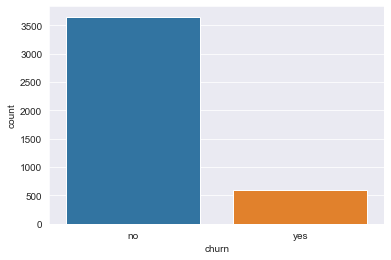

In [5]:
sns.countplot(data = train, x = "churn")

### Na początek trochę feature engineeringu

#### Mogłoby się wydawać, że klienci są w jakiś sposób zróżnicowani ze względu na stawki opłat. Informacja ta mogła by nieść za sobą ciekawe informacje. Jednak w naszym przypadku stawki opłat są takie same dla każdego klienta. Na poniższych wykresach widać, że rozkład opłat za minutę rozmów jest w każdym przypadku symetryczny. Występuje także bardzo mała wariancja więc wygląda na to, że mamy tutaj do czynienia z błędami zaokrągleń. Z tego względu zmienna dotycząca opłat zostanie usunięta.

Text(0.5, 0, 'International charge')

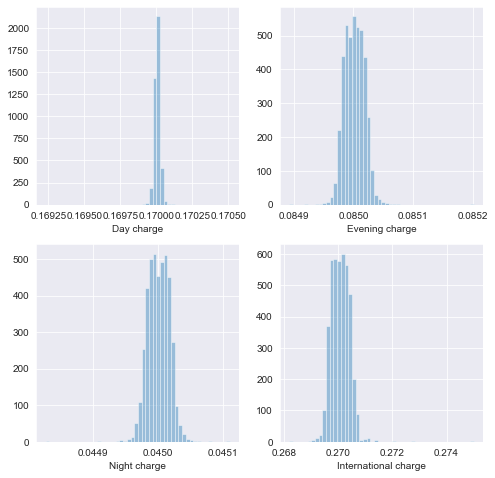

In [6]:
plt.figure(figsize = (8, 8))
plt.subplot(2, 2, 1)
sns.distplot(train.total_day_charge / train.total_day_minutes, kde = False)
plt.xlabel("Day charge")
plt.subplot(2, 2, 2)
sns.distplot(train.total_eve_charge / train.total_eve_minutes, kde = False)
plt.xlabel("Evening charge")
plt.subplot(2, 2, 3)
sns.distplot(train.total_night_charge / train.total_night_minutes, kde = False)
plt.xlabel("Night charge")
plt.subplot(2, 2, 4)
sns.distplot(train.total_intl_charge / train.total_intl_minutes, kde = False)
plt.xlabel("International charge")

In [7]:
for i in ["day", "eve", "night", "intl"]:
    print(i, "charge:", np.round((train["total_" + i + "_charge"] / train["total_" + i + "_minutes"]), 2).unique())

day charge: [0.17  nan]
eve charge: [0.09 0.08  nan]
night charge: [0.05 0.04  nan]
intl charge: [0.27  nan]


#### W ramach inżynierii cech dodamy zmienne zawierające liczbę minut na połączenie w poszczególnych częściach doby oraz w połączeniach międzynarodowych, łączną liczbę połączeń, sumę minut w połączeniach. Zostaną dodane również udziały liczby połączeń i minut w łącznych ich wartościach. Zostanie także dodana zmienna będąca odsetkiem liczby połączeń w ramach obsługi klienta w liczbie połączeń ogółem.

In [8]:
def preprocessor(data):
    data["day_minutes_per_call"] = np.where(data.total_day_minutes == 0, 0, data.total_day_minutes / data.total_day_calls)
    data["eve_minutes_per_call"] = np.where(data.total_eve_minutes == 0, 0, data.total_eve_minutes / data.total_eve_calls)
    data["night_minutes_per_call"] = np.where(data.total_night_minutes == 0, 0, data.total_night_minutes / data.total_night_calls)
    data["intl_minutes_per_call"] = np.where(data.total_intl_minutes == 0, 0, data.total_intl_minutes / data.total_intl_calls)
    data["total_minutes"] = data.total_day_minutes + data.total_eve_minutes + data.total_night_minutes + data.total_intl_minutes
    data["total_calls"] = data.total_day_minutes + data.total_eve_calls + data.total_night_calls + data.total_intl_calls
    data["day_minutes_perc"] = data.total_day_minutes / data.total_minutes
    data["eve_minutes_perc"] = data.total_eve_minutes / data.total_minutes
    data["night_minutes_perc"] = data.total_night_minutes / data.total_minutes
    data["intl_minutes_perc"] = data.total_intl_minutes / data.total_minutes
    data["day_calls_perc"] = data.total_day_calls / data.total_calls
    data["eve_calls_perc"] = data.total_eve_calls / data.total_calls
    data["night_calls_perc"] = data.total_night_calls / data.total_calls
    data["intl_calls_perc"] = data.total_intl_calls / data.total_calls
    data["customer_service_calls_perc"] = data.number_customer_service_calls / data.total_calls
    data = data.drop(columns = ["total_day_charge", "total_eve_charge", \
                                "total_night_charge", "total_intl_charge", \
                                "number_customer_service_calls", "total_day_minutes", \
                               "total_eve_minutes", "total_night_minutes", "total_intl_minutes", \
                               "total_day_calls", "total_eve_calls", "total_night_calls", "total_intl_calls"])
    return data

In [9]:
train = preprocessor(train)

#### Poniżej znajdują się statystyki opisowe podsumowujące zbiór danych po przeprowadzeniu feature engineeringu. Zmienne dla których miary przeciętne czy zróżnicowania nie mają wartości to rzecz jasna zmienne nienumeryczne.

In [10]:
train.describe(include = "all")

state  account_length      area_code international_plan  \
count   4250     4250.000000           4250               4250   
unique    51             NaN              3                  2   
top       WV             NaN  area_code_415                 no   
freq     139             NaN           2108               3854   
mean     NaN      100.236235            NaN                NaN   
std      NaN       39.698401            NaN                NaN   
min      NaN        1.000000            NaN                NaN   
25%      NaN       73.000000            NaN                NaN   
50%      NaN      100.000000            NaN                NaN   
75%      NaN      127.000000            NaN                NaN   
max      NaN      243.000000            NaN                NaN   

       voice_mail_plan  number_vmail_messages churn  day_minutes_per_call  \
count             4250            4250.000000  4250           4250.000000   
unique               2                    NaN     2                   NaN   
top                 no                    NaN    no                   NaN   
freq              3138                    NaN  3652                   NaN   
mean               NaN               7.631765   NaN              1.886142   
std                NaN              13.439882   NaN              0.732099   
min                NaN               0.000000   NaN              0.000000   
25%                NaN               0.000000   NaN              1.391506   
50%                NaN               0.000000   NaN              1.800000   
75%                NaN              16.000000   NaN              2.270948   
max                NaN              52.000000   NaN              7.223333   

        eve_minutes_per_call  night_minutes_per_call  intl_minutes_per_call  \
count            4250.000000             4250.000000            4250.000000   
unique                   NaN                     NaN                    NaN   
top                      NaN                     NaN                    NaN   
freq                     NaN                     NaN                    NaN   
mean                2.089816                2.097368               3.167113   
std                 0.752324                0.715018               2.328619   
min                 0.000000                0.000000               0.000000   
25%                 1.607895                1.608496               1.685714   
50%                 1.983125                2.010736               2.518333   
75%                 2.463855                2.472720               3.850000   
max                15.608333                7.124242              18.200000   

        total_minutes  total_calls  day_minutes_perc  eve_minutes_perc  \
count     4250.000000  4250.000000       4250.000000       4250.000000   
unique            NaN          NaN               NaN               NaN   
top               NaN          NaN               NaN               NaN   
freq              NaN          NaN               NaN               NaN   
mean       591.217459   384.701953          0.303374          0.339181   
std         88.825009    60.977620          0.076456          0.074013   
min        284.300000   180.900000          0.000000          0.000000   
25%        531.825000   343.725000          0.253723          0.290724   
50%        591.600000   384.550000          0.303631          0.338872   
75%        650.500000   425.800000          0.355295          0.387008   
max        885.000000   609.500000          0.578614          0.631107   

        night_minutes_perc  intl_minutes_perc  day_calls_perc  eve_calls_perc  \
count          4250.000000        4250.000000     4250.000000     4250.000000   
unique                 NaN                NaN             NaN             NaN   
top                    NaN                NaN             NaN             NaN   
freq                   NaN                NaN             NaN             NaN   
mean              0.339691           0.017754 

### Wizualizacja danych

#### Poniżej widać że zmienne numeryczne nie są bardzo silnie ze sobą skorelowane. Wyjątkiem są procent dziennych połączeń i dzienna liczba minut na połączenie oraz procent międzynarodowych połączeń i międzynarodowa liczba minut na połączenie. Są one ze sobą ujemnie skorelowane. Pomimo dość silnej korelacji dwie z nich nie będą usunięte ze zbioru, ponieważ nie ma pomiędzy nimi zależności funkcyjnej. W związku z tym nie będą one niosły dokładnie takich samych informacji więc może to pomóc naszemu algorytmowi w osiągnięciu lepszego wyniku w konkursie.

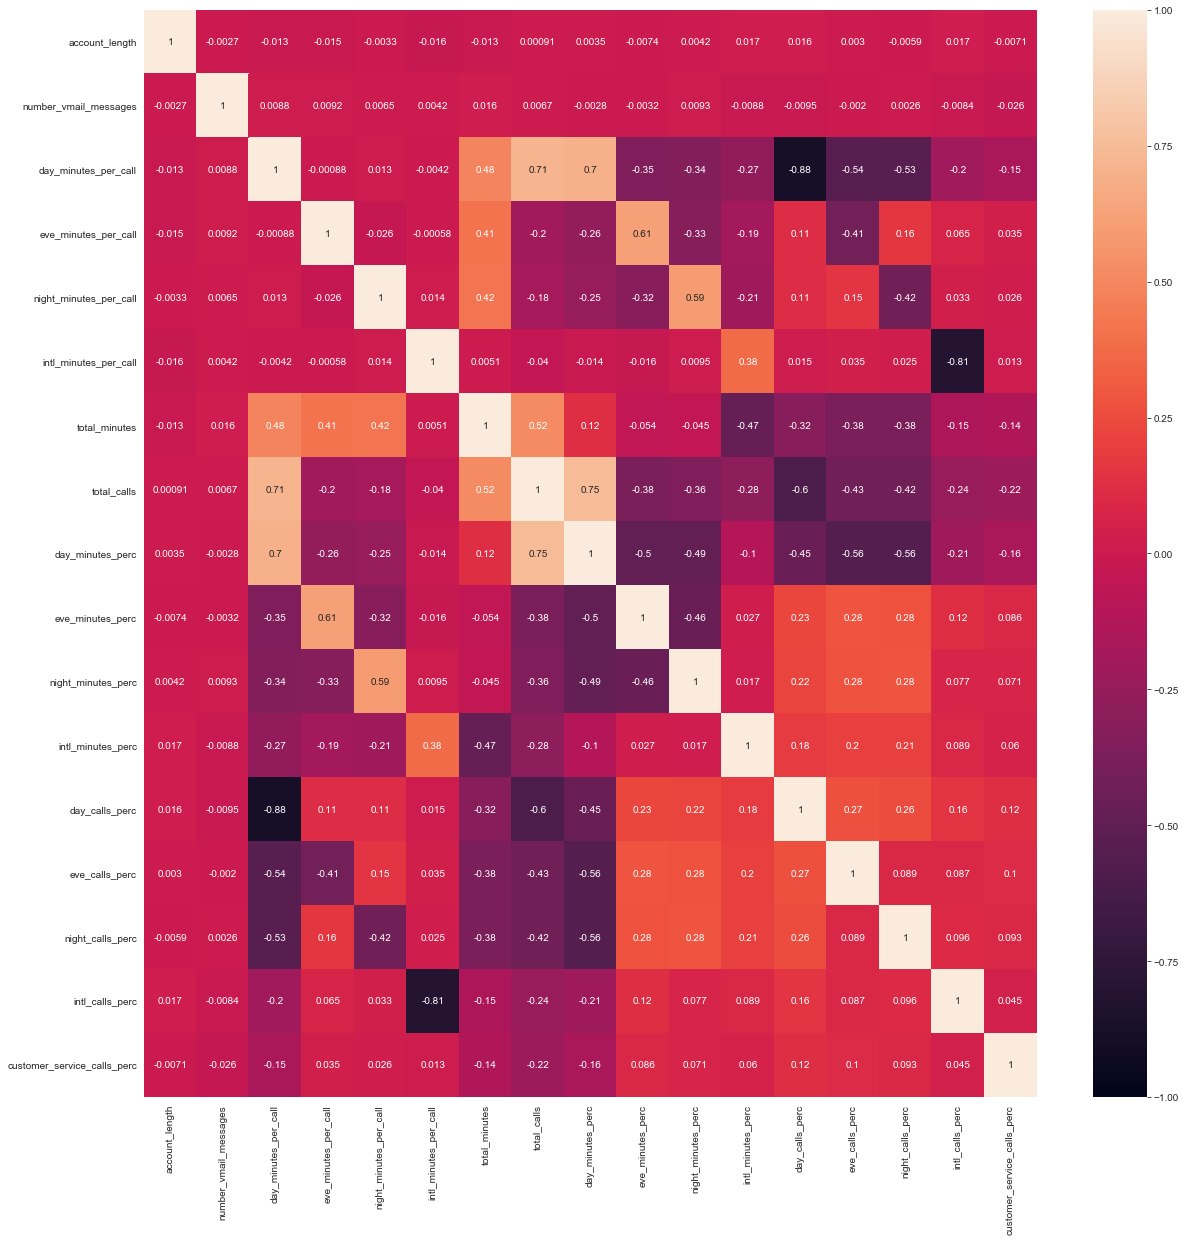

In [11]:
plt.figure(figsize = (20, 20))
sns.heatmap(train.select_dtypes(exclude = "object").corr(method = "spearman"), annot = True, vmin = -1, vmax = 1)

#### Na poniższym wykresie widać, że pomiędzy wyżej wymienionymi zmiennymi zachodzi silna ujemna korelacja. Nie ma ona jednak liniowego charakteru. Gdy nie zobaczę wykresu rozrzutu, możliwość wystąpienia nieliniowości powoduje, że liczę korelację pomiędzy zmiennymi z wykorzystaniem współczynnika korelacji rang Spearmana. Współczynnik korelacji liniowej Pearsona pozwala szacować jedynie liniowe korelacje.

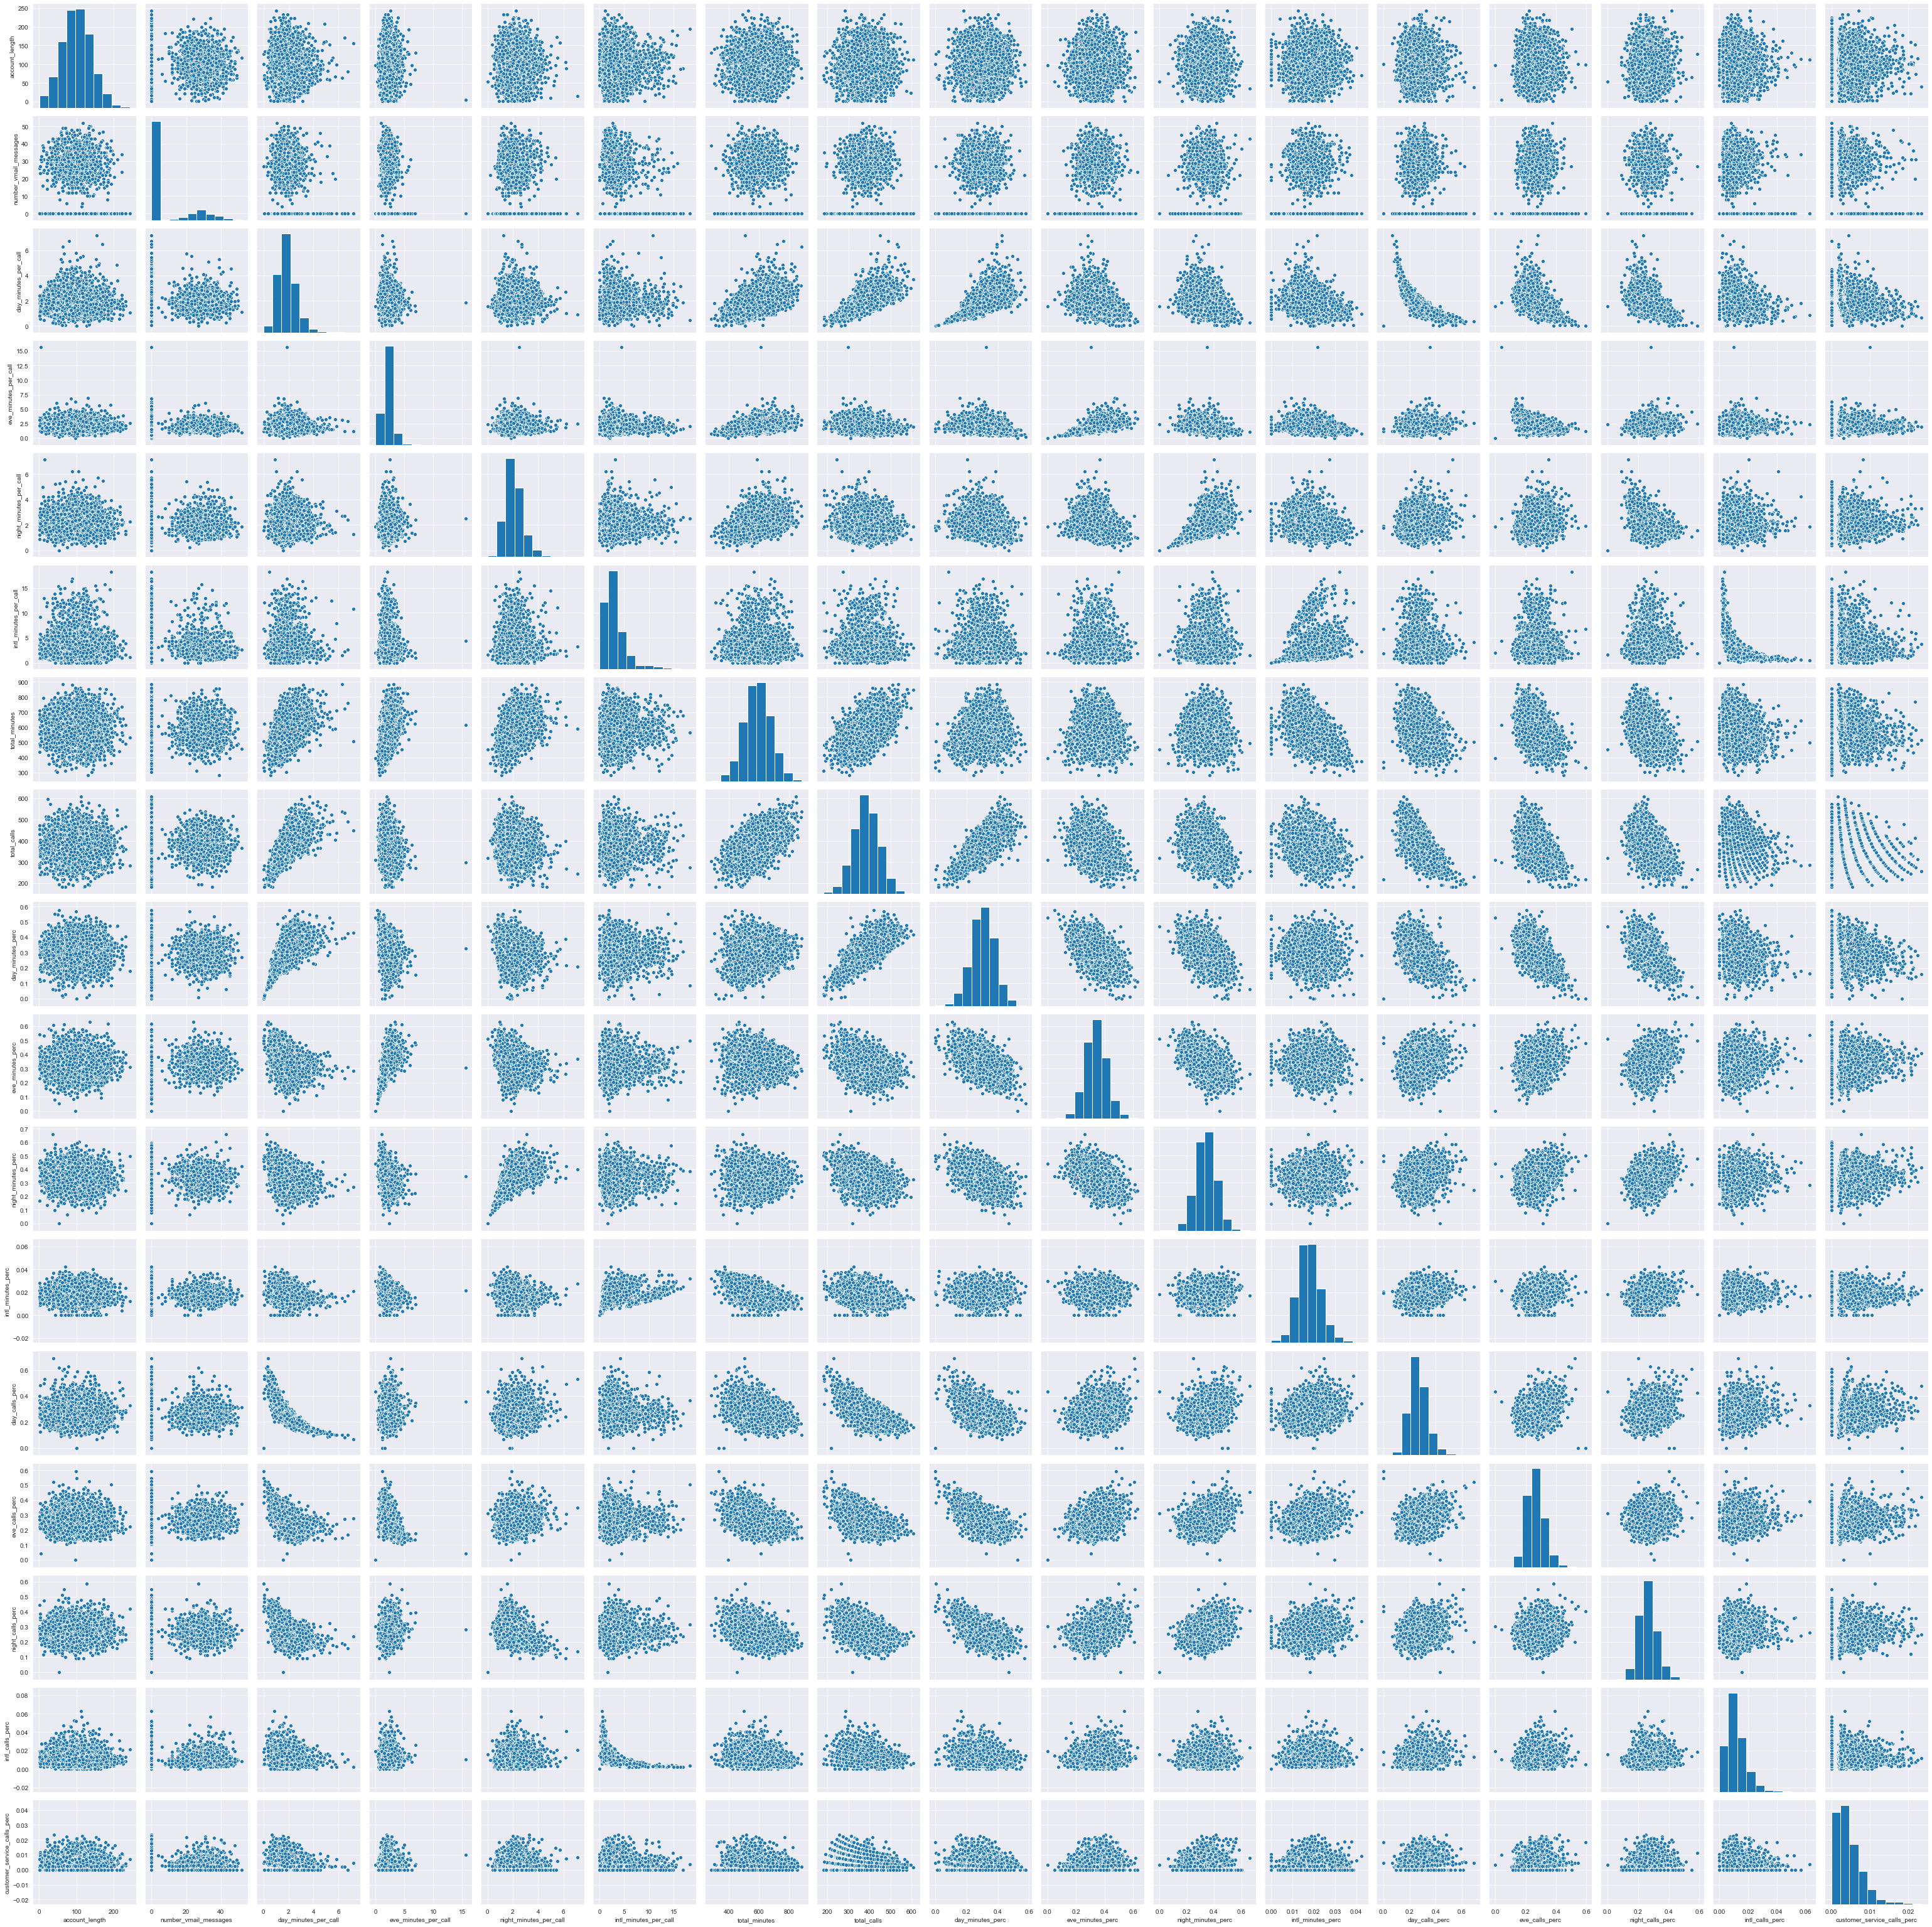

In [12]:
sns.pairplot(train)

#### Poniżej przedstawię na wykresach pudełkowych oraz histogramach rozkłady zmiennych numerycznych dla klientów którzy zrezygnowali z usług firmy telekomunikacyjnej oraz tych którzy przedłużyli umowę. Niektóre zmienne dość dobrze są różnicowane przez zmienną churn, w niektórych z kolei występują na pierwszy rzut oka tylko subtelne różnice.

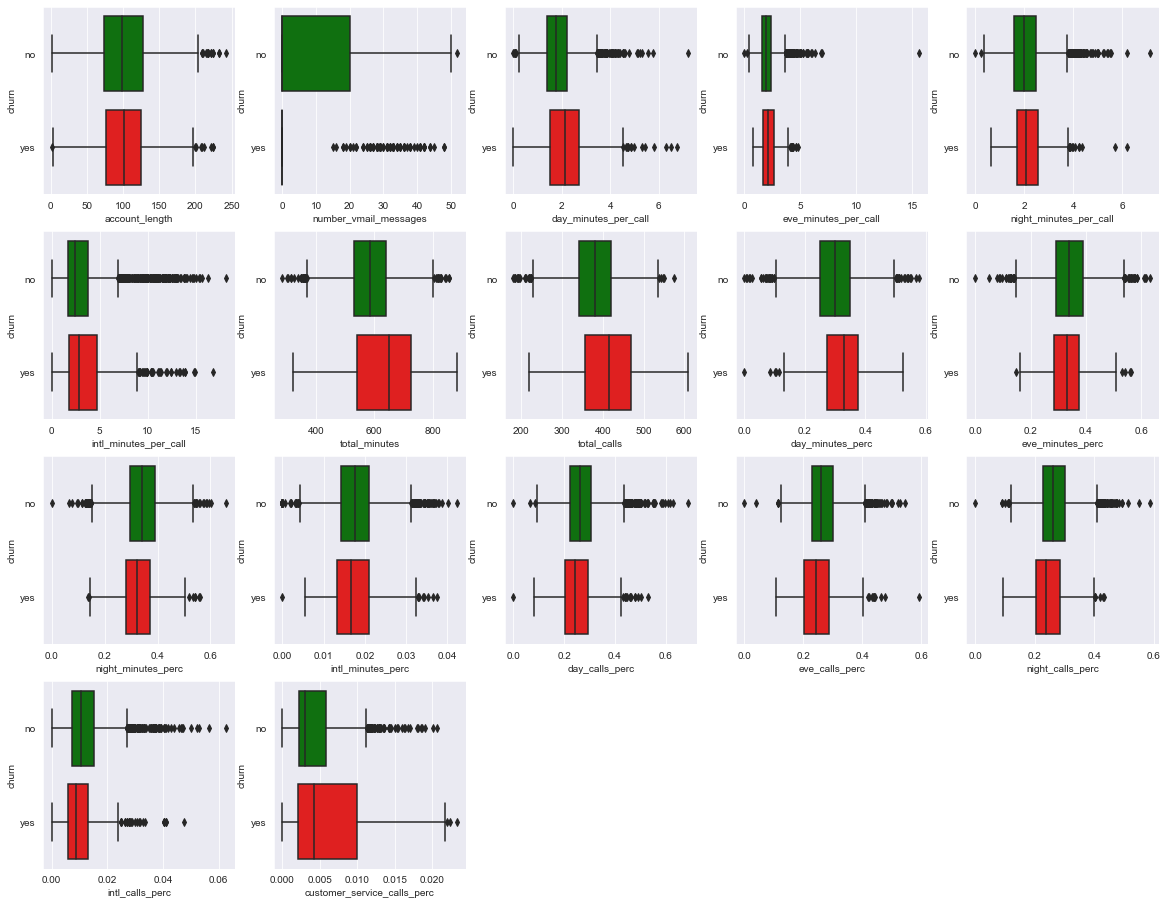

In [13]:
numerical_columns = train.select_dtypes(exclude = "object").columns

plt.figure(figsize = (20, 20))
for i in np.arange(len(numerical_columns)) + 1:
    plt.subplot(5, 5, i)
    sns.boxplot(y = train["churn"], x = train[numerical_columns[i - 1]], palette = ["green", "red"])

#### Histogramy bardzo fajnie pokazują różnice w rozkładach analizowanych zmiennych u klientów którzy zrezygnowali i nie zrezygnowali z usług firmy. Już na podstawie wykresu można ustalić, że klienci u których połączenia z serwisem stanowią ponad 1,2% wszystkich połączeń prawie napewno zrezygnują z dalszego korzystania z usług. Podobna sytuacja występuje chociażby w zmiennej total_calls. Tego typu wzorców powinien uczyć się dobry model.

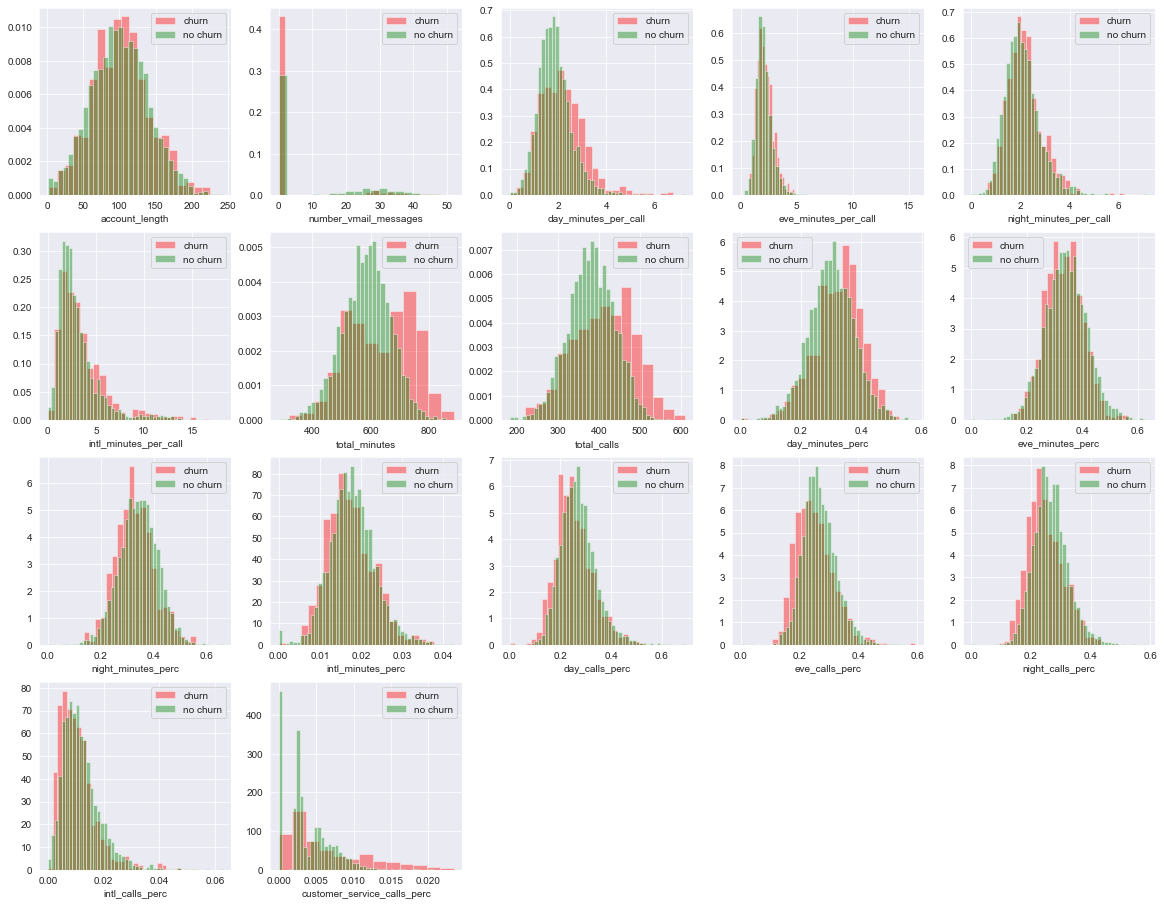

In [14]:
plt.figure(figsize = (20, 20))
for i in np.arange(len(numerical_columns)) + 1:
    plt.subplot(5, 5, i)
    sns.distplot(train.loc[train.churn == "yes",numerical_columns[i-1]], label = "yes", color = "red", kde = False, norm_hist = True)
    sns.distplot(train.loc[train.churn == "no",numerical_columns[i-1]], label = "no", color = "green", kde = False, norm_hist = True)
    plt.legend(labels=['churn','no churn'])

#### Poniżej zobaczymy jak prezentuje się zbiór treningowy po zredukowaniu liczby zmiennych numerycznych do dwóch, aby można było przedstawić go na dwuwymiarowym wykresie. Do tego wykorzystam metody redukcji wymiarowości PCA, TSNE oraz Isomap które należą do grupy algorytmów uczenia nienadzorowanego.

Text(0.5, 1.0, 'Isomap')

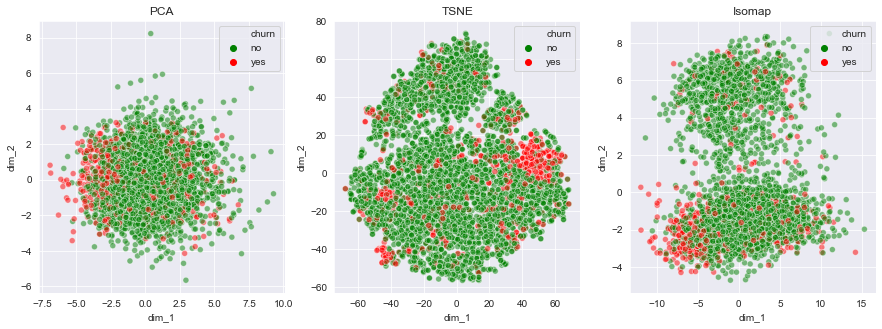

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

scaler = StandardScaler()
num_train = train.select_dtypes(exclude = "object")
num_train_scaled = scaler.fit_transform(num_train)
num_train_scaled

pca = PCA(n_components = 2)
tsne = TSNE(n_components = 2, n_jobs = -1, random_state = 123)
isomap = Isomap(n_components = 2, n_jobs = -1)

num_train_reduced_pca = pd.DataFrame(pca.fit_transform(num_train_scaled), columns = ["dim_1", "dim_2"])
num_train_reduced_pca["churn"] = train.churn

num_train_reduced_tsne = pd.DataFrame(tsne.fit_transform(num_train_scaled), columns = ["dim_1", "dim_2"])
num_train_reduced_tsne["churn"] = train.churn

num_train_reduced_isomap = pd.DataFrame(isomap.fit_transform(num_train_scaled), columns = ["dim_1", "dim_2"])
num_train_reduced_isomap["churn"] = train.churn

plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(data = num_train_reduced_pca, x = "dim_1", y = "dim_2", hue = "churn", alpha = 0.5, palette = ["green", "red"])
plt.title("PCA")
plt.subplot(1, 3, 2)
sns.scatterplot(data = num_train_reduced_tsne, x = "dim_1", y = "dim_2", hue = "churn", alpha = 0.5, palette = ["green", "red"])
plt.title("TSNE")
plt.subplot(1, 3, 3)
sns.scatterplot(data = num_train_reduced_isomap, x = "dim_1", y = "dim_2", hue = "churn", alpha = 0.5, palette = ["green", "red"])
plt.title("Isomap")

#### Powyżej widać że klienci którzy zrezygnowali i nie zrezygnowali nie są idealnie od siebie odseparowani, ale nie są rozmieszczeni w sposób losowy (tworzą dośc wyraźne skupiska). Klienci którzy zrezygnowali są na lewym wykresie skupieni głównie po lewej stronie, na środkowym widzimy skupisko po prawej stronie a na prawym z kolei w lewym dolnym rogu. Aby polepszyć tą sytuację zobaczmy jak przedstawiają się klienci którzy posiadają różne poziomy cech jakościowych.

#### Do zwizualizowania zmiennych kategorycznych posłużyłem się wykresami słupkowymi przedstawiającymi odsetek klientów którzy zrezygnowali z usług firmy dla każdego poziomu danej cechy. Widać tutaj, że klienci mający wykupiony pakiet międzynarodowy są znacznie bardziej skłonni do odejścia aniżeli pozostali. Należy jednak mieć na uwadze liczebność obserwacji posiadających ten wariant cechy. Jest ona niewielka więc ta zmienna pewnie nie przyczyni się w silnym stopniu na poprawe modelu. Takie podejście do analizy zmiennych jakościowych ma zastosowanie do każdej zmiennej i jej poziomów.

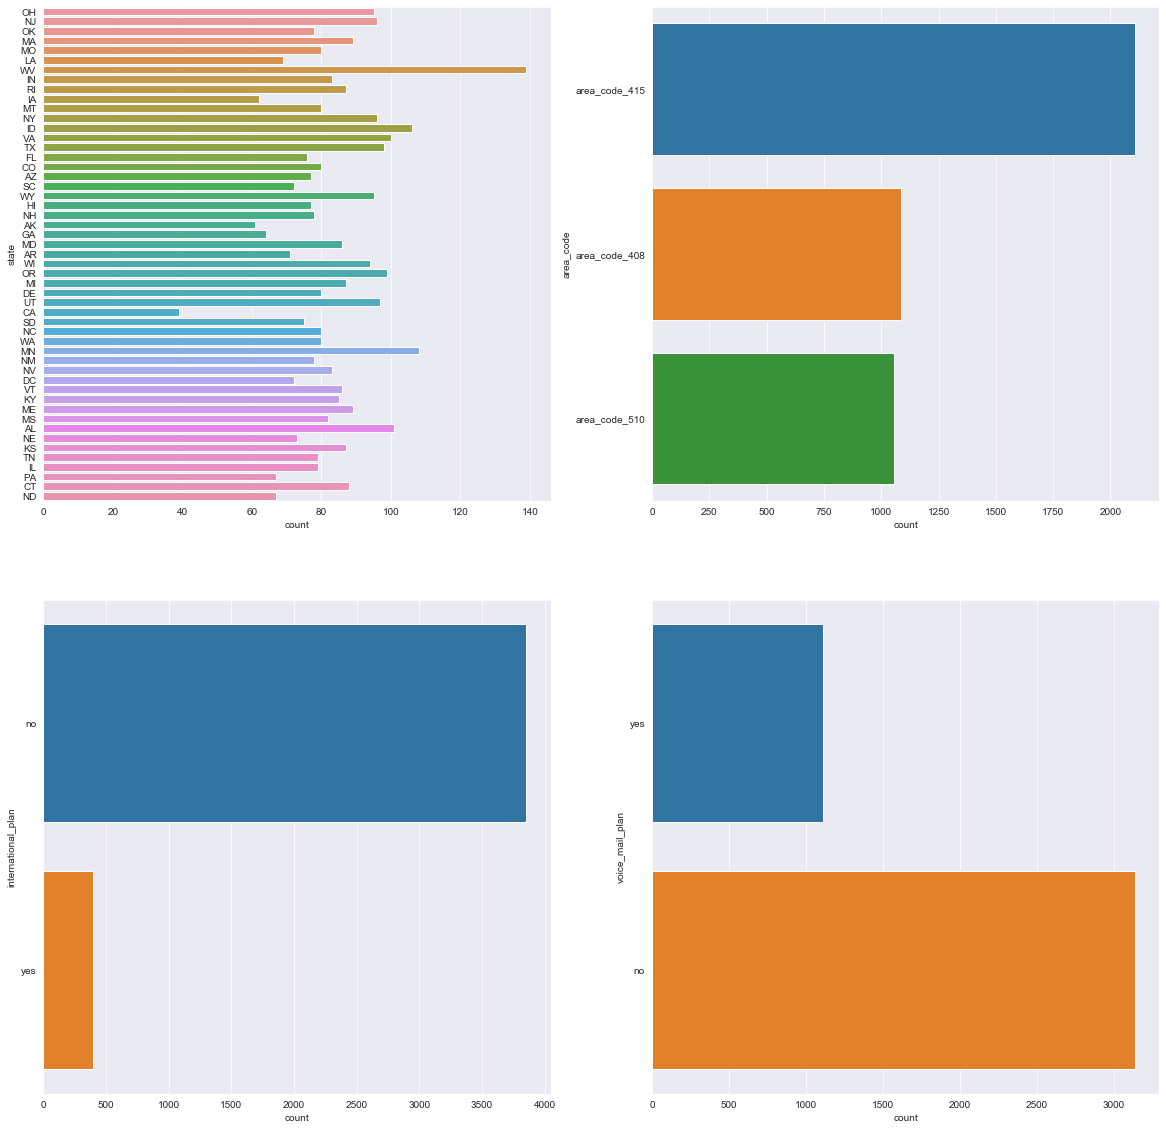

In [16]:
categorical_features = train.select_dtypes(include = "object").drop(columns = "churn").columns

plt.figure(figsize = (20, 20))
for i in np.arange(len(categorical_features)) + 1:
    plt.subplot(2, 2, i)
    sns.countplot(data = train, y = categorical_features[i - 1])

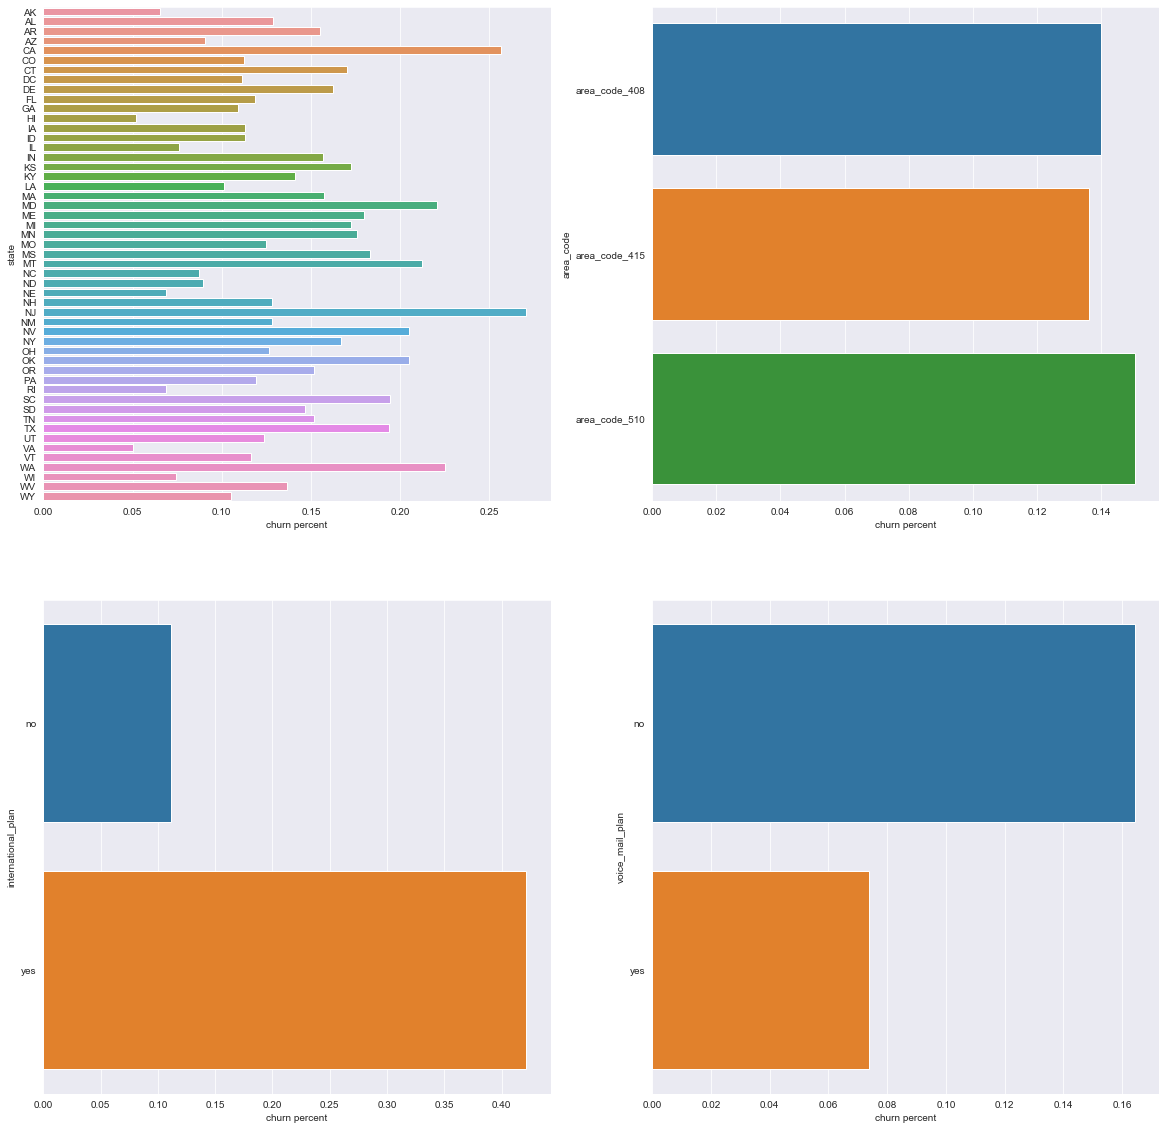

In [17]:
categorical_features = train.select_dtypes(include = "object").drop(columns = "churn").columns

plt.figure(figsize = (20, 20))
for i in np.arange(len(categorical_features)) + 1:
    plt.subplot(2, 2, i)
    x = train.groupby([categorical_features[i - 1], "churn"]).agg(n = (categorical_features[i - 1], "count")).reset_index()
    x["N"] = x.groupby(categorical_features[i - 1])["n"].transform("sum")
    x["perc"] = x.n / x.N
    sns.barplot(data = x.query("churn == 'yes'"), y = categorical_features[i - 1], x = "perc")
    plt.xlabel("churn percent")                                                   

### Istotność zmiennych

#### Poniżej zweryfikuję istotność zmiennych w analizowanym zbiorze danych. Wykorzystam do tego przedstawiony w dalszej części algorytm lasów losowych. Będę musiał także skorzystać z przedstawionych w dalszej części transformacji zbioru danych (transformacja zmiennych nienumerycznych jest niezbędna do implementowania modeli z modułu scikit learn). Istotność zmiennych będzie obliczona 100 krotnie na losowo wybranym podzbiorze analizowanego zbioru danych. Liczba jego obserwacji stanowić będzie 75% obserwacji zbioru pierwotnego. To pozwoli mi dodatkowo ocenić jaka jest istotność zmiennych w przypadku różnych podziałów i zbadać np. ich rozkłady.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

numerical_features = train.drop(columns = "churn").select_dtypes(exclude = "object").columns
categorical_features = train.drop(columns = "churn").select_dtypes(include = "object").columns

numerical_transformer = Pipeline(steps = [
    ("transformer", StandardScaler())
])

categorical_transformer = Pipeline(steps = [
    ("encoder", OneHotEncoder(handle_unknown = "ignore"))
])

data_transformer = ColumnTransformer(transformers = [
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features)
])


model = Pipeline(steps = [
    ("data_preprocessor", data_transformer),
    ("algorithm", RandomForestClassifier())
])


importance_table = pd.DataFrame()

for i in range(100):
    
    sample_data = train.sample(frac = 0.75, replace = False)

    model.fit(sample_data.drop(columns = "churn"), sample_data.churn)

    categorical_features_model = (model.named_steps["data_preprocessor"].transformers_[1][1].
     named_steps["encoder"].get_feature_names(categorical_features))

    model_features = pd.concat([pd.Series(numerical_features), pd.Series(categorical_features_model)])
    importance = model.named_steps["algorithm"].feature_importances_

    results = (pd.DataFrame({"feature": model_features, 
                                      "importance": importance,
                                     "sample": i + 1}))
    
    importance_table = pd.concat([importance_table, results])

##### Na poniższych wykresach pudełkowych jest dosyć wyraźnie wyodrębnionych pięć grup zmiennych. Najsilniej na zmienną docelową wpływają zmienne customer_service_calls_perc, total_minutes oraz total_calls. Zmienne state oraz area_code są nieistotne więc zostaną wykluczone z dalszej analizy. Dodatkowo usunięcie tych zmiennych skróci czas trenowania algorytmów uczenia maszynowego.

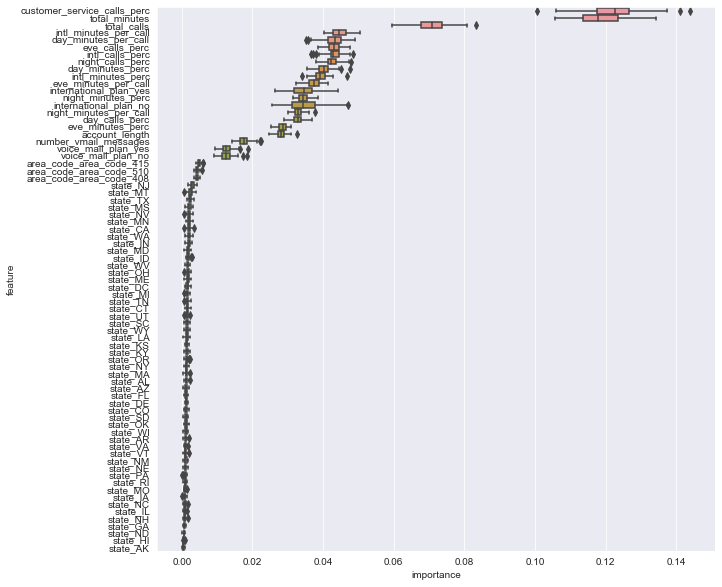

In [19]:
order = (importance_table.groupby("feature").agg(median = ("importance", "median")).reset_index().
         sort_values(by = "median", ascending = False).feature)

plt.figure(figsize = (10, 10))
sns.boxplot(data = importance_table, y = "feature", x = "importance", order = order)

In [20]:
def preprocessor(data):
    data["day_minutes_per_call"] = np.where(data.total_day_minutes == 0, 0, data.total_day_minutes / data.total_day_calls)
    data["eve_minutes_per_call"] = np.where(data.total_eve_minutes == 0, 0, data.total_eve_minutes / data.total_eve_calls)
    data["night_minutes_per_call"] = np.where(data.total_night_minutes == 0, 0, data.total_night_minutes / data.total_night_calls)
    data["intl_minutes_per_call"] = np.where(data.total_intl_minutes == 0, 0, data.total_intl_minutes / data.total_intl_calls)
    data["total_minutes"] = data.total_day_minutes + data.total_eve_minutes + data.total_night_minutes + data.total_intl_minutes
    data["total_calls"] = data.total_day_minutes + data.total_eve_calls + data.total_night_calls + data.total_intl_calls
    data["day_minutes_perc"] = data.total_day_minutes / data.total_minutes
    data["eve_minutes_perc"] = data.total_eve_minutes / data.total_minutes
    data["night_minutes_perc"] = data.total_night_minutes / data.total_minutes
    data["intl_minutes_perc"] = data.total_intl_minutes / data.total_minutes
    data["day_calls_perc"] = data.total_day_calls / data.total_calls
    data["eve_calls_perc"] = data.total_eve_calls / data.total_calls
    data["night_calls_perc"] = data.total_night_calls / data.total_calls
    data["intl_calls_perc"] = data.total_intl_calls / data.total_calls
    data["customer_service_calls_perc"] = data.number_customer_service_calls / data.total_calls
    data = data.drop(columns = ["total_day_charge", "total_eve_charge", \
                                "total_night_charge", "total_intl_charge", \
                                "number_customer_service_calls", "total_day_minutes", \
                               "total_eve_minutes", "total_night_minutes", "total_intl_minutes", \
                               "total_day_calls", "total_eve_calls", "total_night_calls", "total_intl_calls",
                               "state", "area_code"])
    return data

In [21]:
train = preprocessor(pd.read_csv("train.csv"))

### Podział zbioru na treningowy i testowy

#### Jak już napisałem powyżej, mamy do czynienia ze zbiorem niezbalansowanym. W takich przypadkach przy podziale na zbiór treningowy i testowy w celu uniknięcia obciążenia próbkowania powinno się zastosować losowanie warstwowe. Dodatkowo, w celach demonstracyjnych pokażę technikę under i over samplingu. W przypadku under samplingu tracimy dużą część obserwacji więc metoda ta nie powinna być stosowana w przypadku gdy nasz zbiór nie zawiera dużej liczby obserwacji. Oversampling i undersampling przeprowadzę na wcześniej podzielonym zbiorze treningowym.

##### Losowanie warstwowe

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = (train_test_split(train.drop(columns = "churn"), 
                                                     train.churn, test_size = 0.2, stratify = train.churn, random_state = 42))


print("Proporcje w oryginalnym zbiorze:")
print(train.value_counts("churn", normalize = True), "\n")

print("Proporcje w zbiorze treningowym:")
print(pd.DataFrame({"churn": y_train}).value_counts("churn", normalize = True), "\n")

print("Proporcje w zbiorze testowym:")
print(pd.DataFrame({"churn": y_test}).value_counts("churn", normalize = True))

Proporcje w oryginalnym zbiorze:
churn
no     0.859294
yes    0.140706
dtype: float64 

Proporcje w zbiorze treningowym:
churn
no     0.859412
yes    0.140588
dtype: float64 

Proporcje w zbiorze testowym:
churn
no     0.858824
yes    0.141176
dtype: float64


##### Undersampling

In [23]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state = 42)

X_train_under_sampling, y_train_under_sampling = rus.fit_resample(X_train, y_train)

print("Liczebności w zbiorze testowym po zastosowaniu undersamplingu")
print(pd.DataFrame({"churn": y_train_under_sampling}).value_counts("churn"))

Liczebności w zbiorze testowym po zastosowaniu undersamplingu
churn
yes    478
no     478
dtype: int64


##### Oversampling

In [24]:
from imblearn.over_sampling import SMOTENC

categorical_features = train.drop(columns = "churn").select_dtypes(include = "object").columns
categorical_features_position = [train.drop(columns = "churn").columns.get_loc(feature) for feature in categorical_features]


smotenc = SMOTENC(categorical_features = categorical_features_position, random_state = 42, k_neighbors = 5)

X_train_over_sampling, y_train_over_sampling = smotenc.fit_resample(X_train, y_train)

print("Liczebności w zbiorze testowym po zastosowaniu oversamplingu")
print(pd.DataFrame({"churn": y_train_over_sampling}).value_counts("churn"))

Liczebności w zbiorze testowym po zastosowaniu oversamplingu
churn
yes    2922
no     2922
dtype: int64


##### Połączę zbiory treningowe w jeden

In [25]:
stratify = pd.concat([X_train, y_train], axis = 1)
undersampling = pd.concat([X_train_under_sampling, y_train_under_sampling], axis = 1)
oversampling = pd.concat([X_train_over_sampling, y_train_over_sampling], axis = 1)

train_datasets = {"stratify": stratify, "undersampling": undersampling, "oversampling": oversampling}

##### W dalszej analizie będę chciał zbadać stabilność każdego rozważanego algorytmu użytego z danym transformatorem danych oraz sposobem podziału zbioru (stabilność uzyskanych wyników można także mierzyć dla każdego transformatora oraz każdego z trzech powyższych sposobów podziału zbioru danych). Będę wielokrotnie dzielił dane na zbiory treningowe i testowe. Chcąc uniknąć wielokrotnego powielania kodu poniżej stworzę funkcję która będzie zwracać podzielone dane. 

In [26]:
def sampler(data):
    
    from sklearn.model_selection import train_test_split
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.over_sampling import SMOTENC
        
    
    X_train, X_test, y_train, y_test = (train_test_split(data.drop(columns = "churn"), 
                                                     data.churn, test_size = 0.2, stratify = data.churn))
    
    rus = RandomUnderSampler()
    
    X_train_under_sampling, y_train_under_sampling = rus.fit_resample(X_train, y_train)
    
    
    categorical_features = data.drop(columns = "churn").select_dtypes(include = "object").columns
    
    categorical_features_position = [data.drop(columns = "churn").columns.get_loc(feature) for feature in categorical_features]
    
    smotenc = SMOTENC(categorical_features = categorical_features_position, k_neighbors = 5)
    
    X_train_over_sampling, y_train_over_sampling = smotenc.fit_resample(X_train, y_train)
    
    
    stratify = pd.concat([X_train, y_train], axis = 1)
    
    undersampling = pd.concat([X_train_under_sampling, y_train_under_sampling], axis = 1)
    
    oversampling = pd.concat([X_train_over_sampling, y_train_over_sampling], axis = 1)

    
    train_datasets = {"stratify": stratify, "undersampling": undersampling, "oversampling": oversampling}
    
    
    return (train_datasets, X_test, y_test)

### Tworzenie pipeline-u

#### W tej części stworzę machine learningowy pipeline który posłuży mi do utworzenia tabeli porównawczej zawierającej algorytmy, transformatory, techniki przygotowania zbioru użytego do wytrenowania algorytmu oraz miary skuteczności modelu takie jak dokładność (accuracy - odsetek wszystkich poprawnie zaklasyfikowanych klientów przez model), precyzja (precision - odsetek klientów którzy faktycznie odeszli wśród wszystkich klientów zaklasyfikowanych przez model jako churn) oraz pełność (recall - odsetek klientów sklasyfikowanych jako churn wśród klientów którzy zrezygnowali z usług firmy.). W przypadku problemu jakim jest churn (odpływ klientów od firmy) najbardziej powinno nam zależeć na pełności (oczywiście przy zachowaniu odpowiedniej precyzji - tutaj należy przyjąć pewien kompromis co zwykle zależy od założeń).  W konkursie kaggle jest stosowana miara dokładności więc głównie na niej się skupię. Należy tutaj zwrócić uwagę, że w przypadku danych nienumerycznych do transformacji zmiennych używam jedynie transformatora OneHotEncoder (w module scikitlearn jest też np. OrdinalEncoder). Wynika to bezpośrednio z faktu, że w zbiorze danych mamy jedynie zmienne należące do skali nominalnej a OrdinalEncodera stosuje się do zmiennych nienumerycznych wyrażonych na skali porządkowej.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

numerical_features = train.drop(columns = "churn").select_dtypes(exclude = "object").columns
categorical_features = train.drop(columns = "churn").select_dtypes(include = "object").columns

numerical_transformer = Pipeline(steps = [
    ("transformer", None)
])

categorical_transformer = Pipeline(steps = [
    ("encoder", OneHotEncoder(handle_unknown = "ignore"))
])

data_transformer = ColumnTransformer(transformers = [
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features)
])

classifier = Pipeline(steps = [
    ("data_preprocessor", data_transformer),
    ("algorithm", None)
])

#### Poniżej zaimportuje wszystko czego będę potrzebował do przestrzeni poszukiwań.

In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, QuantileTransformer

# Algorytmy

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

#### Poniżej z kolei zdefiniuję tą przestrzeń.

In [29]:
dataset_types = ["stratify", "undersampling", "oversampling"]

classifiers = [KNeighborsClassifier(), LogisticRegression(max_iter = 1000), SVC(), 
               RandomForestClassifier(n_jobs = -1, max_depth = 5), ExtraTreesClassifier(n_jobs = -1, max_depth = 5), 
               AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), CatBoostClassifier(silent = True), 
               LGBMClassifier(verbose = -1)]

scalers = [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), Normalizer(), QuantileTransformer(n_quantiles = 100)]

##### Dzięki poniższej pętli stworzę tabelę zawierającą wszystkie niezbędne informacje które pozwolą na ocenę skuteczności powyższych algorytmów, różnych kombinacji transformatorów i sposobów przygotowania zbiorów uczących. Każda kombinacja będzie trenowana i ewaluowana 20 razy na losowo wybranych zbiorach treningowych i testowych.

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

pipeline = Pipeline(steps = [
    ("data_preprocessor", data_transformer),
    ("algorithm", None)
])

comp_table = pd.DataFrame()

epochs = 20

for i in range(epochs):
    train_datasets, X_test, y_test = sampler(train)
    for dataset_type in dataset_types:
        for clf in classifiers:
            for scl in scalers:
                train_dataset = train_datasets[dataset_type]
                    
                params = {"data_preprocessor__numerical__transformer": scl,
                         "algorithm": clf}
                    
                pipeline.set_params(**params)
                
                pipeline.fit(train_dataset.drop(columns = "churn"), train_dataset.churn)
                
                accuracy = accuracy_score(y_test, pipeline.predict(X_test))
                precision = precision_score(y_test, pipeline.predict(X_test), pos_label = "yes", zero_division = 1)
                recall = recall_score(y_test, pipeline.predict(X_test), pos_label = "yes", zero_division = 1)
                
                results = {"algorithm": clf.__class__.__name__,
                          "scaler": scl.__class__.__name__,
                          "dataset_type": dataset_type,
                          "epoch": i + 1,
                          "accuracy": accuracy,
                          "precision": precision,
                          "recall": recall}
                
                comp_table = pd.concat([comp_table, pd.DataFrame(results, index = [0])])

##### W 20 najlepszych wynikach pod względem miary accuracy znalazły się algorytmy LGBMClassifier, XGBClassifier oraz CatBoostClassifier. Wynika stąd że dominują algorytmy uczenia zespołowego które uczą się przez wzmacnianie. Najwyższe wartości miary accuracy osiąga się bez stosowania metod over i undersamplingu. Poniżej znajduje się też top 20 najlepszych kombinacji dla pełności która w rzeczywistym projekcie uczenia maszynowego dotyczącego przewidywania odpływu klientów z firmy jest najistotniejsza (Jak wspomniałem wcześniej przy zachowaniu odpowiedniego poziomu precyzji, ponieważ każdy może stworzyć model który bedzie miał 100% pełność. Wystarczy że model zawsze będzie przewidywał churn - wtedy jednak precyzja takiego modelu będzie wynosić 0).

In [55]:
comp_table.sort_values(by = ["accuracy", "recall"], ascending = [False, False]).head(20)

algorithm               scaler dataset_type  epoch  accuracy  \
0      LGBMClassifier         MaxAbsScaler     stratify     14  0.965882   
0  CatBoostClassifier       StandardScaler     stratify     14  0.965882   
0  CatBoostClassifier         MinMaxScaler     stratify     14  0.965882   
0  CatBoostClassifier         MaxAbsScaler     stratify     14  0.965882   
0  CatBoostClassifier  QuantileTransformer     stratify     14  0.965882   
0      LGBMClassifier         MaxAbsScaler     stratify     17  0.965882   
0      LGBMClassifier  QuantileTransformer     stratify     17  0.965882   
0      LGBMClassifier       StandardScaler     stratify     14  0.963529   
0      LGBMClassifier         MinMaxScaler     stratify     14  0.963529   
0      LGBMClassifier         MinMaxScaler     stratify     16  0.962353   
0       XGBClassifier       StandardScaler     stratify     14  0.961176   
0       XGBClassifier         MinMaxScaler     stratify     14  0.961176   
0       XGBClassifier         MaxAbsScaler     stratify     14  0.961176   
0       XGBClassifier  QuantileTransformer     stratify     14  0.961176   
0  CatBoostClassifier       StandardScaler     stratify     17  0.961176   
0  CatBoostClassifier         MinMaxScaler     stratify     17  0.961176   
0  CatBoostClassifier         MaxAbsScaler     stratify     17  0.961176   
0  CatBoostClassifier  QuantileTransformer     stratify     17  0.961176   
0      LGBMClassifier       StandardScaler     stratify     16  0.961176   
0      LGBMClassifier         MaxAbsScaler     stratify     16  0.961176   

   precision    recall  
0   0.925234  0.825000  
0   0.933333  0.816667  
0   0.933333  0.816667  
0   0.933333  0.816667  
0   0.933333  0.816667  
0   0.941748  0.808333  
0   0.969072  0.783333  
0   0.908257  0.825000  
0   0.923810  0.808333  
0   0.948980  0.775000  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.939394  0.775000  
0   0.957895  0.758333

In [57]:
comp_table.sort_values(by = ["accuracy", "recall"], ascending = [False, False]).head(20)

algorithm               scaler dataset_type  epoch  accuracy  \
0      LGBMClassifier         MaxAbsScaler     stratify     14  0.965882   
0  CatBoostClassifier       StandardScaler     stratify     14  0.965882   
0  CatBoostClassifier         MinMaxScaler     stratify     14  0.965882   
0  CatBoostClassifier         MaxAbsScaler     stratify     14  0.965882   
0  CatBoostClassifier  QuantileTransformer     stratify     14  0.965882   
0      LGBMClassifier         MaxAbsScaler     stratify     17  0.965882   
0      LGBMClassifier  QuantileTransformer     stratify     17  0.965882   
0      LGBMClassifier       StandardScaler     stratify     14  0.963529   
0      LGBMClassifier         MinMaxScaler     stratify     14  0.963529   
0      LGBMClassifier         MinMaxScaler     stratify     16  0.962353   
0       XGBClassifier       StandardScaler     stratify     14  0.961176   
0       XGBClassifier         MinMaxScaler     stratify     14  0.961176   
0       XGBClassifier         MaxAbsScaler     stratify     14  0.961176   
0       XGBClassifier  QuantileTransformer     stratify     14  0.961176   
0  CatBoostClassifier       StandardScaler     stratify     17  0.961176   
0  CatBoostClassifier         MinMaxScaler     stratify     17  0.961176   
0  CatBoostClassifier         MaxAbsScaler     stratify     17  0.961176   
0  CatBoostClassifier  QuantileTransformer     stratify     17  0.961176   
0      LGBMClassifier       StandardScaler     stratify     16  0.961176   
0      LGBMClassifier         MaxAbsScaler     stratify     16  0.961176   

   precision    recall  
0   0.925234  0.825000  
0   0.933333  0.816667  
0   0.933333  0.816667  
0   0.933333  0.816667  
0   0.933333  0.816667  
0   0.941748  0.808333  
0   0.969072  0.783333  
0   0.908257  0.825000  
0   0.923810  0.808333  
0   0.948980  0.775000  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.922330  0.791667  
0   0.939394  0.775000  
0   0.957895  0.758333

##### Gdy rozpatrujemy algoryrmy ze względu na miarę pełności to okazuje się że najlepszy jest algorytm wzmacniania gradientowego (który również jest algorytmem zespołowym uczącym sie przez wzmacnianie). W tej grupie znalazły się również wspomniane wcześniej algorytmy uczenia przez wzmacnianie które osiągają najwyższe wartości precyzji. Jak widać poniżej, osiągnięcie wysokiej wartości pełności odbywa się kosztem utraty precyzji. W takich przypadkach wybiera się najwyższą wartość pełności przy zachowaniu określonego minimum precyzji. Jak już wcześniej wspomniałem, to zwykle jednak zależy od założeń danego projektu. Jak się okazuje, najwyższą pełność osiągają algorytmy wytrenowane na zbiorach w których jest wyeliminowane zjawisko niezbalansowania przez użycie metody undersamplingu.

In [58]:
comp_table.sort_values(by = ["recall", "precision"], ascending = [False, False]).head(20)

algorithm               scaler   dataset_type  epoch  \
0  GradientBoostingClassifier         MinMaxScaler  undersampling     14   
0  GradientBoostingClassifier         MaxAbsScaler  undersampling     14   
0          CatBoostClassifier       StandardScaler  undersampling     14   
0          CatBoostClassifier         MinMaxScaler  undersampling     14   
0          CatBoostClassifier         MaxAbsScaler  undersampling     14   
0          CatBoostClassifier  QuantileTransformer  undersampling     14   
0  GradientBoostingClassifier       StandardScaler  undersampling     14   
0  GradientBoostingClassifier  QuantileTransformer  undersampling     14   
0      RandomForestClassifier       StandardScaler  undersampling     14   
0              LGBMClassifier  QuantileTransformer  undersampling     14   
0              LGBMClassifier         MinMaxScaler  undersampling     14   
0              LGBMClassifier         MaxAbsScaler  undersampling     14   
0              LGBMClassifier       StandardScaler  undersampling     14   
0               XGBClassifier       StandardScaler  undersampling     14   
0               XGBClassifier         MinMaxScaler  undersampling     14   
0               XGBClassifier         MaxAbsScaler  undersampling     14   
0               XGBClassifier  QuantileTransformer  undersampling     14   
0          CatBoostClassifier           Normalizer  undersampling     10   
0          CatBoostClassifier           Normalizer  undersampling     14   
0                         SVC           Normalizer   oversampling     18   

   accuracy  precision    recall  
0  0.872941   0.528302  0.933333  
0  0.871765   0.525822  0.933333  
0  0.874118   0.531100  0.925000  
0  0.874118   0.531100  0.925000  
0  0.874118   0.531100  0.925000  
0  0.874118   0.531100  0.925000  
0  0.869412   0.521127  0.925000  
0  0.869412   0.521127  0.925000  
0  0.871765   0.526316  0.916667  
0  0.903529   0.605556  0.908333  
0  0.902353   0.602210  0.908333  
0  0.901176   0.598901  0.908333  
0  0.896471   0.586022  0.908333  
0  0.882353   0.550505  0.908333  
0  0.882353   0.550505  0.908333  
0  0.882353   0.550505  0.908333  
0  0.882353   0.550505  0.908333  
0  0.863529   0.509346  0.908333  
0  0.863529   0.509346  0.908333  
0  0.372941   0.172742  0.908333

### Poniżej przedstawię wykresy pudełkowe przedstawiające algorytmy scalery i typy zborów treningowych dla każdej rozważanej miary.

#### Algorytmy

In [33]:
def make_boxplots(var = "algorithm"):
    
    accuracy_order = (comp_table.groupby(var).agg(median = ("accuracy", "median")).
                      reset_index().sort_values(by = "median", ascending = False)[var])
    precision_order = (comp_table.groupby(var).agg(median = ("precision", "median")).
                  reset_index().sort_values(by = "median", ascending = False)[var])
    recall_order = (comp_table.groupby(var).agg(median = ("recall", "median")).
                      reset_index().sort_values(by = "median", ascending = False)[var])

    plt.figure(figsize = (25, 15))
    plt.subplot(2, 2, 1)
    sns.boxplot(data = comp_table, y = var, x = "accuracy", order = accuracy_order)
    plt.ylabel("")
    plt.subplot(2, 2, 2)
    sns.boxplot(data = comp_table, y = var, x = "precision", order = precision_order)
    plt.ylabel("")
    plt.subplot(2, 2, 3)
    sns.boxplot(data = comp_table, y = var, x = "recall", order = recall_order)
    plt.ylabel("")

##### Algorytmy uczenia zespołowego które uczą się przez wzmacnianie wyraźnie dominują nad resztą. Nie tylko pod względem rozważanych miar ale również pod względem stabilności uzyskiwanych wyników.

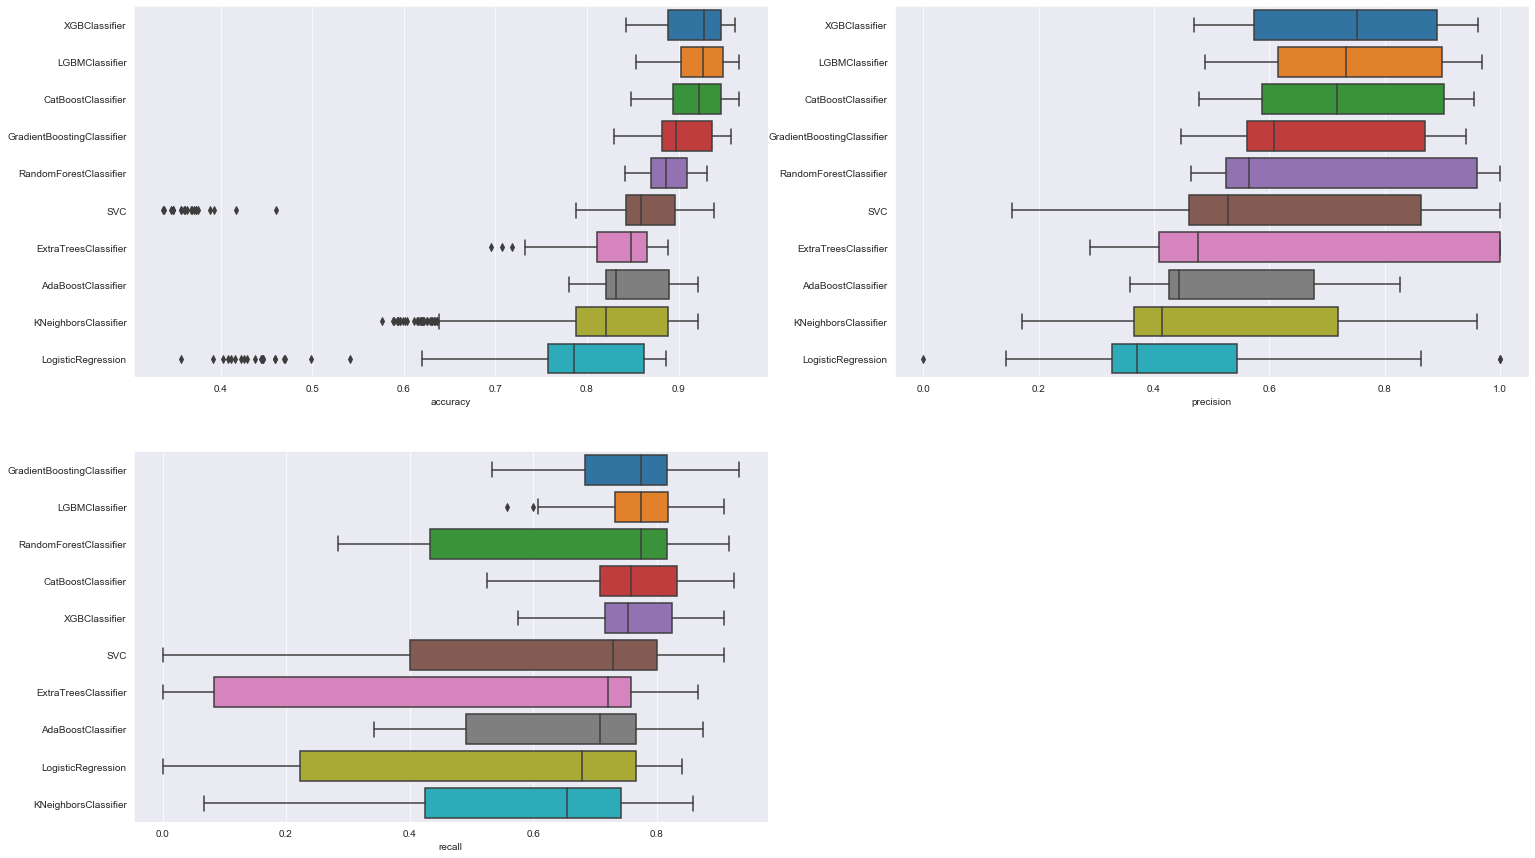

In [34]:
make_boxplots(var = "algorithm")

#### Scalery 

##### W każdym przypadku najlepiej sprawuje się standaryzacja. Należy dodać, że można stosować różne transformery do różnych kolumn. Tutaj zastosowałem jeden transformer dla wszystkich kolumn numerycznych.

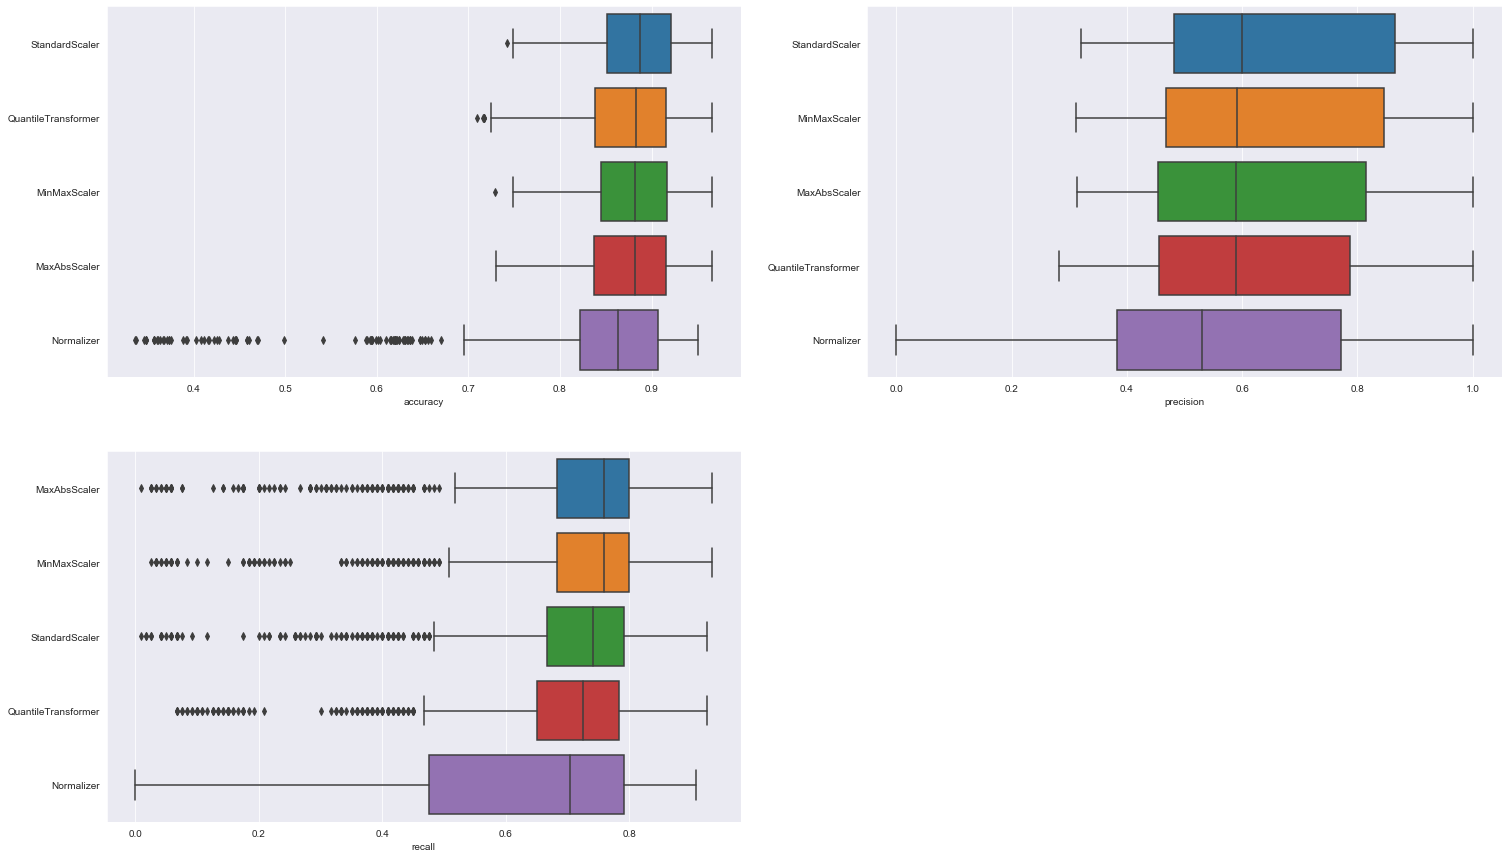

In [35]:
make_boxplots(var = "scaler")

#### Typy danych treningowych

##### Do wytrenowania finalnego algorytmu oczywiście nie nie będę używał techniki over i under samplingu ponieważ podział zbioru z wykorzystaniem losowania warstwowego pozwala na uzyskanie wyższych wartości miary accuracy (dokładności) która jest stosowana do oceny modelu na platformie Kaggle. Dodatkowo wyniki dla dla tego sposobu przygotowania zbioru treningowego są bardziej stabilne. Jednakże podczas pracy nad rzeczywistym projektem uczenia maszynowego dotyczącego klasyfikacji churnu należało by się poważnie zastanowić nad wyborem sposobu przygotowania danych treningowych, ponieważ pełność uzyskiwana dla losowania warstwowego jest znacznie niższa i dużo mniej stabilna od przypadków w których stosujemy na zbiorze treningowym technikę over czy undersamplingu.

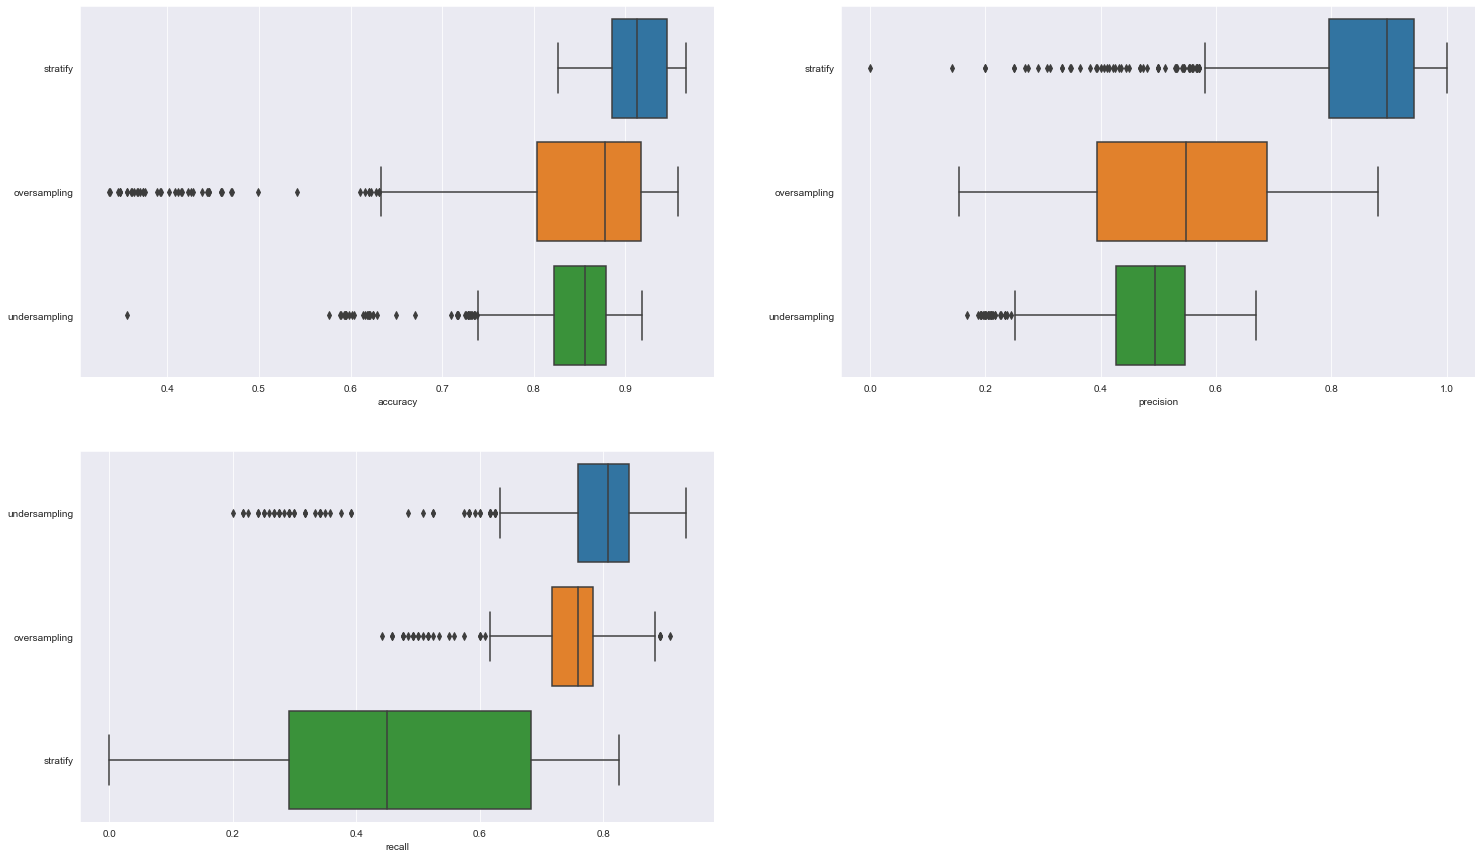

In [36]:
make_boxplots(var = "dataset_type")

##### Poniżej jeszcze pokażę jakie wartości miar osiągają rozważane algorytmy w zależności od sposobu przygotowania zbioru treningowego.

C:\Users\wlamc\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


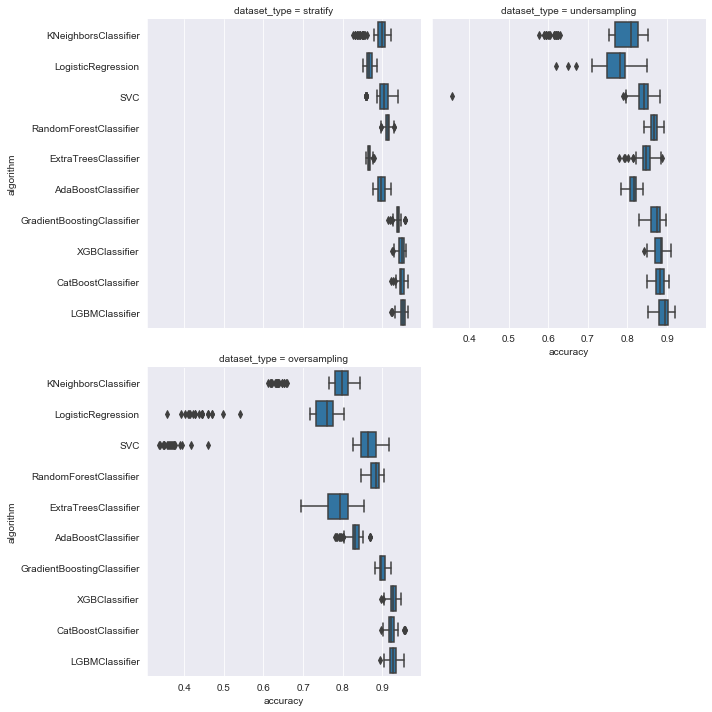

In [37]:
plot = sns.FacetGrid(data = comp_table, col = "dataset_type", col_wrap = 2, height = 5)
plot.map(sns.boxplot, "accuracy", "algorithm")

C:\Users\wlamc\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


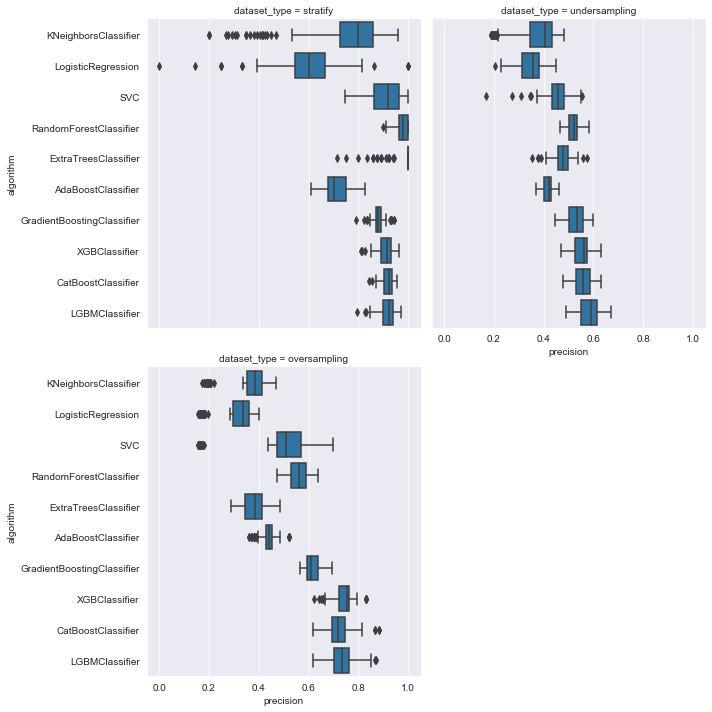

In [38]:
plot = sns.FacetGrid(data = comp_table, col = "dataset_type", col_wrap = 2, height = 5)
plot.map(sns.boxplot, "precision", "algorithm")

C:\Users\wlamc\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


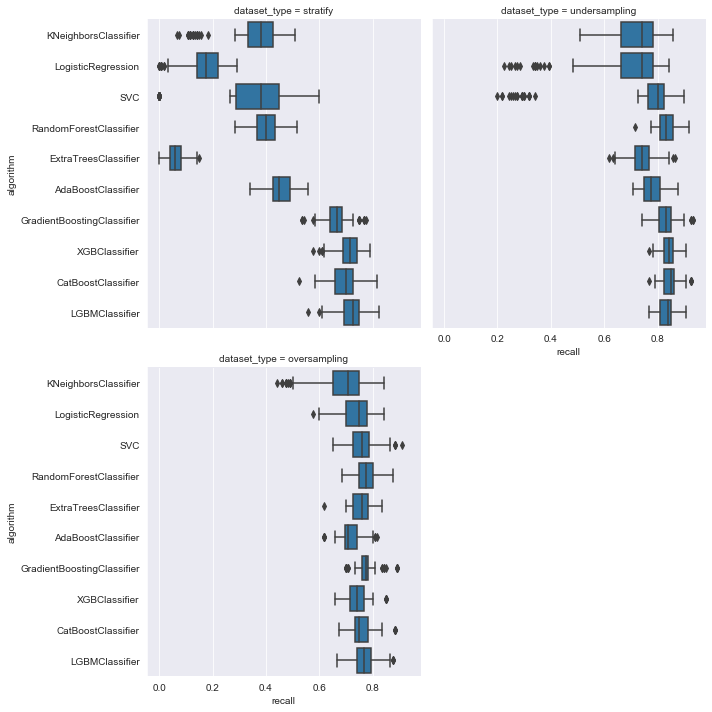

In [39]:
plot = sns.FacetGrid(data = comp_table, col = "dataset_type", col_wrap = 2, height = 5)
plot.map(sns.boxplot, "recall", "algorithm")

##### Z powyższych wykresów wynika, że najlepsze z rozważanych algorytmów to LGBMClassifier, XGBClassifier i CatBoostClassifier. Stworzę więc algorytm zespołowy który będzie je zawierał. Takie podejście do budowania finalnego algorytmu uczenia maszynowego często ogranicza jego wariancję i polepsza zdolności klasyfikacyjne. Zanim jednak to zrobię wyszukam dla każdego z nich najlepszych hiperparametrów używając metody przeszukiwania siatki a następnie sprawdzę jak wyglądają macieże pomyłek dla tych algorytmów. Bardzo dobra sytuacja jest wtedy gdy rozkład błędów jest różny.

###### Przeszukiwanie siatki

##### XGBoost

In [40]:
from sklearn.model_selection import GridSearchCV

xgb_clf = Pipeline(steps = [
    ("data_preprocessor", data_transformer),
    ("algorithm", XGBClassifier(n_jobs = -1, tree_method = "gpu_hist"))
])


xgb_params = {
             "algorithm__learning_rate": [0.001, 0.01, 0.05, 0.1],
             "algorithm__max_depth": [4, 6, 8],
             "algorithm__n_estimators": [300, 500, 700],
             "algorithm__subsample": [0.75, 0.85, 0.95]
}

xgb_clf_grid = GridSearchCV(estimator = xgb_clf, param_grid = xgb_params,
                           scoring = "accuracy", cv = 3, n_jobs = -1)

xgb_clf_grid.fit(train.drop(columns = "churn"), train.churn)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('data_preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('transformer',
                                                                                          QuantileTransformer(n_quantiles=100))]),
                                                                         Index(['account_length', 'number_vmail_messages', 'day_minutes_per_call',
       'eve_minutes_per_call', 'night_minutes_per_call',
       'intl_minutes_per_call', 'total_minutes', 'total_cal...
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                        

##### CatBoost

In [41]:
catboost_clf = Pipeline(steps = [
    ("data_preprocessor", data_transformer),
    ("algorithm", CatBoostClassifier(silent = True))
])


catboost_params = {
             "algorithm__learning_rate": [0.01, 0.05, 0.1],
             "algorithm__depth": [4, 6, 8],
             "algorithm__iterations": [250, 350, 650],
             "algorithm__subsample": [0.75, 0.85, 0.95]
}

catboost_clf_grid = GridSearchCV(estimator = catboost_clf, param_grid = catboost_params,
                           scoring = "accuracy", cv = 3, n_jobs = -1)

catboost_clf_grid.fit(train.drop(columns = "churn"), train.churn)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('data_preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('transformer',
                                                                                          QuantileTransformer(n_quantiles=100))]),
                                                                         Index(['account_length', 'number_vmail_messages', 'day_minutes_per_call',
       'eve_minutes_per_call', 'night_minutes_per_call',
       'intl_minutes_per_call', 'total_minutes', 'total_cal...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['international_plan', 'voice_mail_plan'], dtype='object'))])),
                                       ('algorithm',
  

##### LGBM

In [42]:
lgbm_clf = Pipeline(steps = [
    ("data_preprocessor", data_transformer),
    ("algorithm", LGBMClassifier(verbose = -1, n_jobs = -1, num_leaves = 100))
])


lgbm_params = {
             "algorithm__learning_rate": [0.01, 0.05, 0.1],
             "algorithm__max_depth": [4, 6, 8, 10],
             "algorithm__n_estimators": [500, 700, 850],
             "algorithm__subsample": [0.75, 0.85, 0.95]
}

lgbm_clf_grid = GridSearchCV(estimator = lgbm_clf, param_grid = lgbm_params,
                           scoring = "accuracy", cv = 3, n_jobs = -1)

lgbm_clf_grid.fit(train.drop(columns = "churn"), train.churn)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('data_preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('transformer',
                                                                                          QuantileTransformer(n_quantiles=100))]),
                                                                         Index(['account_length', 'number_vmail_messages', 'day_minutes_per_call',
       'eve_minutes_per_call', 'night_minutes_per_call',
       'intl_minutes_per_call', 'total_minutes', 'total_cal...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['international_plan', 'voice_mail_plan'], dtype='object'))])),
                                       ('algorithm',
  

##### Najlepsze parametry

In [43]:
print("XGBClassifier:", xgb_clf_grid.best_params_, "\n")
print("CatBoostClassifier:", catboost_clf_grid.best_params_, "\n")
print("LGBMClassifier:", lgbm_clf_grid.best_params_)

XGBClassifier: {'algorithm__learning_rate': 0.05, 'algorithm__max_depth': 6, 'algorithm__n_estimators': 500, 'algorithm__subsample': 0.95} 

CatBoostClassifier: {'algorithm__depth': 8, 'algorithm__iterations': 350, 'algorithm__learning_rate': 0.1, 'algorithm__subsample': 0.95} 

LGBMClassifier: {'algorithm__learning_rate': 0.05, 'algorithm__max_depth': 10, 'algorithm__n_estimators': 700, 'algorithm__subsample': 0.75}


##### Najlepsze wyniki

In [44]:
print("XGBClassifier:", xgb_clf_grid.best_score_, "\n")
print("CatBoostClassifier:", catboost_clf_grid.best_score_, "\n")
print("LGBMClassifier:", lgbm_clf_grid.best_score_)

XGBClassifier: 0.9508241331052713 

CatBoostClassifier: 0.9512942783818232 

LGBMClassifier: 0.9534119256751818


##### Przypiszę najlepsze algorytmy do zmiennych

In [45]:
xgb_clf_best = xgb_clf_grid.best_estimator_
catboost_clf_best = catboost_clf_grid.best_estimator_
lgbm_clf_best = lgbm_clf_grid.best_estimator_

##### Macierze pomyłek

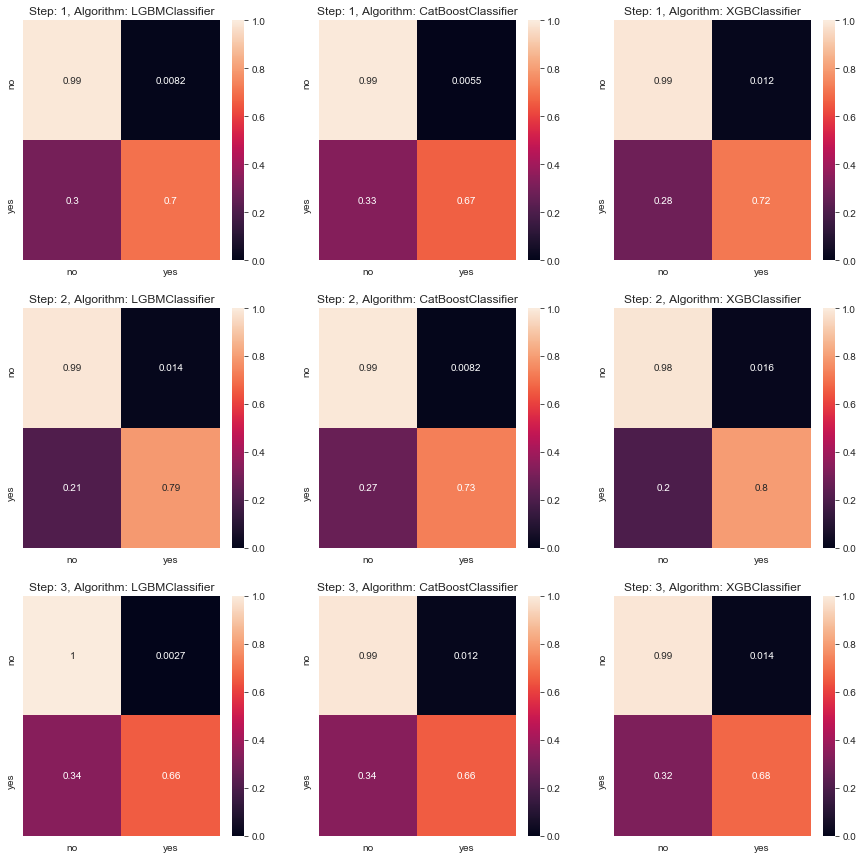

In [46]:
from sklearn.metrics import confusion_matrix


classifiers = [lgbm_clf_best, catboost_clf_best, xgb_clf_best]
names = ["LGBMClassifier", "CatBoostClassifier", "XGBClassifier"]

num = 1

plt.figure(figsize = (15, 15))

for i in range(3):
    train_datasets, X_test, y_test = sampler(train)
    num_alg = 0
    for clf in classifiers:
        
        clf.fit(train_datasets["stratify"].drop(columns = "churn"), train_datasets["stratify"].churn)
        
        pred = clf.predict(X_test)
        
        cm = pd.DataFrame(confusion_matrix(y_test, pred, normalize = "true"), index = ["no", "yes"], columns = ["no", "yes"])
        
        plt.subplot(3, 3, num)
        sns.heatmap(cm, annot = True, vmin = 0, vmax = 1)
        plt.title("Step: {}, Algorithm: {}".format(i + 1, names[num_alg]))
        
        num += 1
        num_alg += 1

##### Powyżej widać że wybrane algorytmy nie popełniają takich samych błędów więc połączenie ich w jeden zespół może okazać się przydatne.

### Porównnie najlepszych algorytmów z ich zespołem

##### W zespole każdy z algorytmów będzie miał swoją wagę która jest w kolumnie prc w poniższej tabeli. Waga jest obliczana na podstawie średniej uzyskanych wyników.

In [47]:
classifiers = [lgbm_clf_best, catboost_clf_best, xgb_clf_best]
names = ["LGBMClassifier", "CatBoostClassifier", "XGBClassifier"]

top = pd.DataFrame()

for i in range(100):
    train_datasets, X_test, y_test = sampler(train)
    num_alg = 0
    for clf in classifiers:
        
        clf.fit(train_datasets["stratify"].drop(columns = "churn"), train_datasets["stratify"].churn)
        
        pred = clf.predict(X_test)
        
        score = accuracy_score(y_test, pred)
        
        results = {"algorithm": names[num_alg],
                  "sample": i + 1,
                  "accuracy": score}
        
        top = pd.concat([top, pd.DataFrame(results, index = [0])])
        num_alg += 1

In [48]:
top_summary = top.groupby("algorithm").agg(mean = ("accuracy", "mean"),\
                            median = ("accuracy", "median")).reset_index().sort_values(by = "algorithm")


top_summary["prc"] = top_summary["mean"] / np.sum(top_summary["mean"])

weights = top_summary["prc"]

top_summary

algorithm      mean    median       prc
0  CatBoostClassifier  0.949035  0.948824  0.332191
1      LGBMClassifier  0.954553  0.955294  0.334123
2       XGBClassifier  0.953306  0.954118  0.333686

##### Stworzę funkcję dzięki której przy tworzeniu algorytmu będącego zespołem trzech nanajlepszych będę mógł ustawić uzyskane wcześniej dla nich parametry.

In [51]:
def new_best_params_dict(clf_grid):
    new_dict = dict()
    new_dict_keys = pd.Series(clf_grid.best_params_.keys()).str.replace("algorithm__", "")
    dict_values = list(clf_grid.best_params_.values())
    
    for i in range(len(new_dict_keys)):
        new_dict.setdefault(new_dict_keys[i], dict_values[i])
        
    return new_dict

##### Poniżej tworzę wspomniany powyżej algorytm oraz tabelę zawierającą miary dokładności dla 100 losowych podziałów zbioru danych. Pozwoli mi to na ostateczne porównanie rozważanych algorytmów i wyłonienie najlepszego z nich.

In [52]:
from sklearn.ensemble import VotingClassifier

Pipeline(steps = [
    ("data_preprocessor", data_transformer),
    ("algorithm", None)
])

voting = VotingClassifier(estimators = [
    ("catboost", CatBoostClassifier(silent = True).set_params(**new_best_params_dict(catboost_clf_grid))),
    ("lgbm", LGBMClassifier(verbose = -1).set_params(**new_best_params_dict(lgbm_clf_grid))),
    ("xgb", XGBClassifier().set_params(**new_best_params_dict(xgb_clf_grid)))
], voting = "soft", weights = weights, n_jobs = -1)

voting_clf = Pipeline(steps = [
    ("data_preprocessor", data_transformer),
    ("algorithm", voting)
])

classifiers = [catboost_clf_best, lgbm_clf_best, xgb_clf_best, voting_clf]
classifiers_names = ["CatBoostClassifier", "LGBMClassifier", "XGBClassifier", "VotingClassifier"]

alg_comp = pd.DataFrame()

for i in range(100):
    
    train_datasets, X_test, y_test = sampler(train)
    
    for j in range(len(classifiers)):
        
        clf = classifiers[j]
        
        clf.fit(train_datasets["stratify"].drop(columns = "churn"), train_datasets["stratify"].churn)
        
        pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        
        results = {"algorithm": classifiers_names[j],
                  "sample": i,
                  "accuracy": accuracy}
        
        alg_comp = pd.concat([alg_comp, pd.DataFrame(results, index = [0])])

##### Okazuje się, że zespół najlepszych klasyfikatorów sprawuje się lepiej od ich pojedynczych wersji. Dodatkowo cechuje go większa stabilność. Zostanie on więc wykorzystany do klasyfikacji klientów ze zbioru testowego z platformy Kaggle.

In [53]:
(alg_comp.groupby("algorithm").agg(median = ("accuracy", "median"),
                                  mean = ("accuracy", "mean")).
             reset_index().sort_values(by = "median", ascending = False))

algorithm    median      mean
2    VotingClassifier  0.955294  0.954494
1      LGBMClassifier  0.954118  0.953659
3       XGBClassifier  0.952941  0.952553
0  CatBoostClassifier  0.950588  0.950541

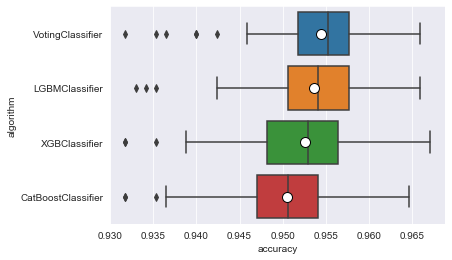

In [54]:
clf_order = (alg_comp.groupby("algorithm").agg(median = ("accuracy", "median")).
             reset_index().sort_values(by = "median", ascending = False).algorithm)
sns.boxplot(data = alg_comp, y = "algorithm", x = "accuracy", showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"}, order = clf_order)

##### Przed ostateczną ewaluacją wytrenuje finalny algorytm na całym zbiorze treningowym.

In [ ]:
voting_clf.fit(train.drop(columns = "churn"), train.churn)

##### Poniżej przewiduję churn dla zbioru testowego i zapisuję plik (csv) w domyślnym katalogu.

In [143]:
test_id = test.id

test_vars = preprocessor(test.drop(columns = "id"))

churn = voting_clf.predict(test_vars)

churn_submission = pd.DataFrame({"id": test_id, "churn": churn})

churn_submission.to_csv("churn_submission.csv", index = False)

### Stworzony algorytm na zbiorze testowym uzyskał dokładność 0.96444. Całkiem nieźle :)